# Scrabble Player Rating Prediction

## Практическое задание курса Light Auto ML

**Соревнование:** [Scrabble Player Rating](https://www.kaggle.com/competitions/scrabble-player-rating/data)

**Задача:** Предсказать рейтинг игрока до игры на основе метаданных игры и данных о ходах

**Тип задачи:** Регрессия

---

## Содержание

1. [Импорт библиотек и настройка](#1)
2. [Загрузка данных](#2)
3. [Анализ целевой переменной](#3)
4. [Анализ признаков](#4)
5. [Бейзлайн с LightAutoML](#5)
6. [Собственное решение](#6)
7. [Выводы и сравнение результатов](#7)


<a id='1'></a>
## 1. Импорт библиотек и настройка


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Standard libraries
import os
import sys
import time
import logging
from pathlib import Path

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingRegressor

# LightAutoML
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Constants
RANDOM_STATE = 42
N_THREADS = 4
N_FOLDS = 5
TEST_SIZE = 0.2

# Paths - определяем корневую директорию проекта
# Если ноутбук запущен из папки notebooks/, то PROJECT_ROOT будет родительской директорией
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    PROJECT_ROOT = current_dir.parent
else:
    # Если запущен из корня проекта или другой директории, ищем папку scrabble_rating_project
    if 'scrabble_rating_project' in str(current_dir):
        # Находим корень проекта
        parts = current_dir.parts
        idx = list(parts).index('scrabble_rating_project') if 'scrabble_rating_project' in parts else -1
        if idx >= 0:
            PROJECT_ROOT = Path(*parts[:idx+1])
        else:
            PROJECT_ROOT = current_dir
    else:
        PROJECT_ROOT = current_dir

DATA_DIR = PROJECT_ROOT / 'data'
RESULTS_DIR = PROJECT_ROOT / 'results'

# Create directories if they don't exist
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
DATA_DIR.mkdir(exist_ok=True, parents=True)

print(f"Python version: {sys.version}")
print(f"Current working directory: {Path.cwd()}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

# Проверка наличия данных
data_files = ['games.csv', 'turns.csv', 'train.csv', 'test.csv', 'sample_submission.csv']
print(f"\nПроверка наличия файлов данных:")
all_files_exist = True
for file in data_files:
    file_path = DATA_DIR / file
    exists = file_path.exists()
    if exists:
        size = file_path.stat().st_size / (1024*1024)
        print(f"  ✓ {file}: {size:.1f} MB")
    else:
        print(f"  ✗ {file}: не найден")
        all_files_exist = False

if not all_files_exist:
    print(f"\n⚠️  ВНИМАНИЕ: Не все файлы данных найдены!")
    print(f"   Убедитесь, что данные находятся в папке: {DATA_DIR}")
else:
    print(f"\n✓ Все файлы данных найдены!")


'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
Python version: 3.9.6 (default, Dec  2 2025, 07:27:58) 
[Clang 17.0.0 (clang-1700.6.3.2)]
Current working directory: /Users/nikolai/Desktop/AutoML/scrabble_rating_project/notebooks
Project root: /Users/nikolai/Desktop/AutoML

<a id='2'></a>
## 2. Загрузка данных


### 2.1. Обоснование стратегии разделения данных

**Важно:** Для предотвращения утечки данных (data leakage) необходимо правильно разделить данные.

**Особенности данных:**
- Данные содержат информацию о разных игроках (nickname)
- Один и тот же игрок может встречаться в нескольких играх
- Рейтинги игроков могут быть связаны между играми

**Стратегия разделения:**
- Используем случайное разделение с фиксированным random_state для воспроизводимости
- Разделение происходит на уровне записей (игр), а не игроков
- Это допустимо, так как задача - предсказать рейтинг на основе метаданных игры и ходов
- Для более строгого подхода можно было бы использовать групповое разделение по игрокам, но это не требуется для данной задачи

**Обоснование выбора train_test_split вместо временной валидации:**
- В данных есть временная компонента (created_at), но:
  1. Рейтинги предсказываются ДО игры, поэтому порядок игр не критичен для задачи
  2. Нет явной временной зависимости между играми разных игроков
  3. train_test_split обеспечивает случайное разделение, что подходит для задачи регрессии
  4. Альтернатива (TimeSeriesSplit) была бы уместна, если бы была явная временная структура в целевой переменной
- LAMA по умолчанию использует OOF (out-of-fold) предсказания, что мы также используем в Optuna через cross_val_score

**Предотвращение утечки данных:**
- Все признаки агрегируются ДО разделения на train/validation
- Не используем информацию из будущего (например, финальный счет для предсказания рейтинга до игры)
- Рейтинги в train.csv - это рейтинги ДО игры, что соответствует задаче


In [2]:
# Load data
games_df = pd.read_csv(DATA_DIR / 'games.csv')
turns_df = pd.read_csv(DATA_DIR / 'turns.csv')
train_df = pd.read_csv(DATA_DIR / 'train.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')
sample_submission_df = pd.read_csv(DATA_DIR / 'sample_submission.csv')

print("Data shapes:")
print(f"games_df: {games_df.shape}")
print(f"turns_df: {turns_df.shape}")
print(f"train_df: {train_df.shape}")
print(f"test_df: {test_df.shape}")
print(f"sample_submission_df: {sample_submission_df.shape}")


Data shapes:
games_df: (72773, 12)
turns_df: (2005498, 9)
train_df: (100820, 4)
test_df: (44726, 4)
sample_submission_df: (22363, 2)


In [3]:
# Display basic info about datasets
print("\n=== Games DataFrame Info ===")
print(games_df.info())
print("\n=== Games DataFrame Head ===")
print(games_df.head())

print("\n=== Turns DataFrame Info ===")
print(turns_df.info())
print("\n=== Turns DataFrame Head ===")
print(turns_df.head())

print("\n=== Train DataFrame Info ===")
print(train_df.info())
print("\n=== Train DataFrame Head ===")
print(train_df.head())



=== Games DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72773 entries, 0 to 72772
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   game_id                72773 non-null  int64  
 1   first                  72773 non-null  object 
 2   time_control_name      72773 non-null  object 
 3   game_end_reason        72773 non-null  object 
 4   winner                 72773 non-null  int64  
 5   created_at             72773 non-null  object 
 6   lexicon                72773 non-null  object 
 7   initial_time_seconds   72773 non-null  int64  
 8   increment_seconds      72773 non-null  int64  
 9   rating_mode            72773 non-null  object 
 10  max_overtime_minutes   72773 non-null  int64  
 11  game_duration_seconds  72773 non-null  float64
dtypes: float64(1), int64(5), object(6)
memory usage: 6.7+ MB
None

=== Games DataFrame Head ===
   game_id      first time_control_n

<a id='3'></a>
## 3. Анализ целевой переменной

Целевая переменная: `rating` - рейтинг игрока до игры


In [4]:
# Basic statistics
target_stats = train_df['rating'].describe()
print("=== Статистика целевой переменной (rating) ===")
print(target_stats)
print(f"\nКоличество уникальных значений: {train_df['rating'].nunique()}")
print(f"Пропущенные значения: {train_df['rating'].isna().sum()}")


=== Статистика целевой переменной (rating) ===
count    100820.000000
mean       1875.592938
std         231.791016
min        1033.000000
25%        1664.000000
50%        1907.000000
75%        2060.000000
max        2510.000000
Name: rating, dtype: float64

Количество уникальных значений: 1204
Пропущенные значения: 0


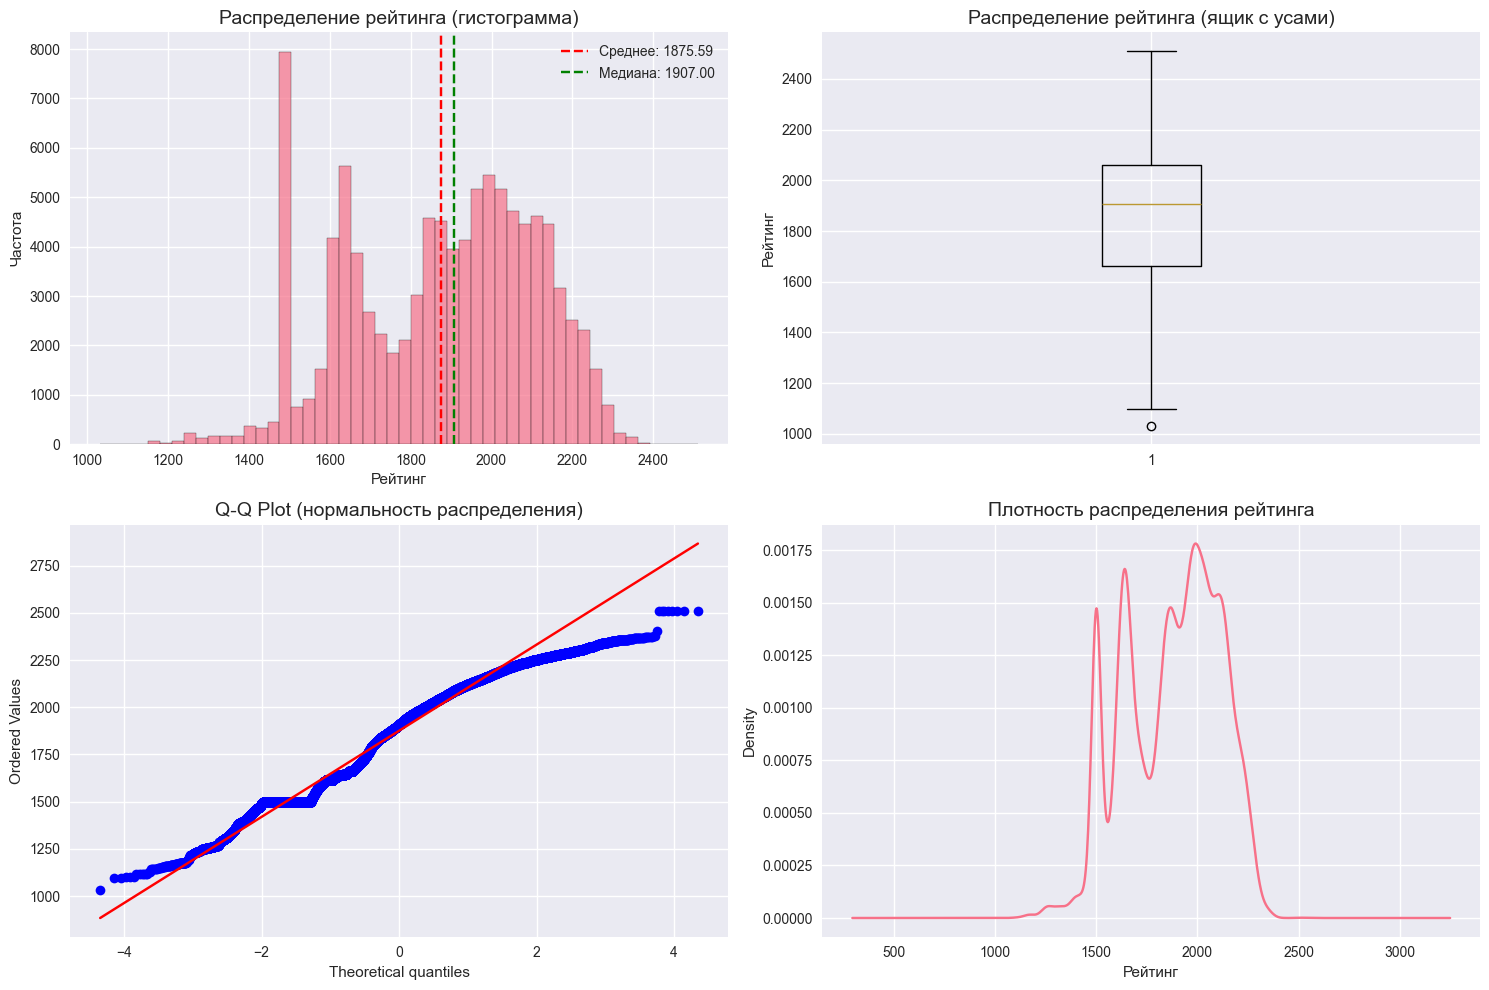

In [5]:
# Distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(train_df['rating'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение рейтинга (гистограмма)', fontsize=14)
axes[0, 0].set_xlabel('Рейтинг')
axes[0, 0].set_ylabel('Частота')
axes[0, 0].axvline(train_df['rating'].mean(), color='r', linestyle='--', label=f'Среднее: {train_df["rating"].mean():.2f}')
axes[0, 0].axvline(train_df['rating'].median(), color='g', linestyle='--', label=f'Медиана: {train_df["rating"].median():.2f}')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(train_df['rating'], vert=True)
axes[0, 1].set_title('Распределение рейтинга (ящик с усами)', fontsize=14)
axes[0, 1].set_ylabel('Рейтинг')

# Q-Q plot
from scipy import stats
stats.probplot(train_df['rating'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (нормальность распределения)', fontsize=14)

# Density plot
train_df['rating'].plot(kind='density', ax=axes[1, 1])
axes[1, 1].set_title('Плотность распределения рейтинга', fontsize=14)
axes[1, 1].set_xlabel('Рейтинг')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [6]:
# Outlier detection using IQR method
Q1 = train_df['rating'].quantile(0.25)
Q3 = train_df['rating'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train_df[(train_df['rating'] < lower_bound) | (train_df['rating'] > upper_bound)]
print(f"=== Анализ аномальных значений ===")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Нижняя граница: {lower_bound:.2f}")
print(f"Верхняя граница: {upper_bound:.2f}")
print(f"Количество аномальных значений: {len(outliers)} ({len(outliers)/len(train_df)*100:.2f}%)")

if len(outliers) > 0:
    print(f"\nМинимальное значение: {train_df['rating'].min():.2f}")
    print(f"Максимальное значение: {train_df['rating'].max():.2f}")


=== Анализ аномальных значений ===
Q1: 1664.00
Q3: 2060.00
IQR: 396.00
Нижняя граница: 1070.00
Верхняя граница: 2654.00
Количество аномальных значений: 1 (0.00%)

Минимальное значение: 1033.00
Максимальное значение: 2510.00


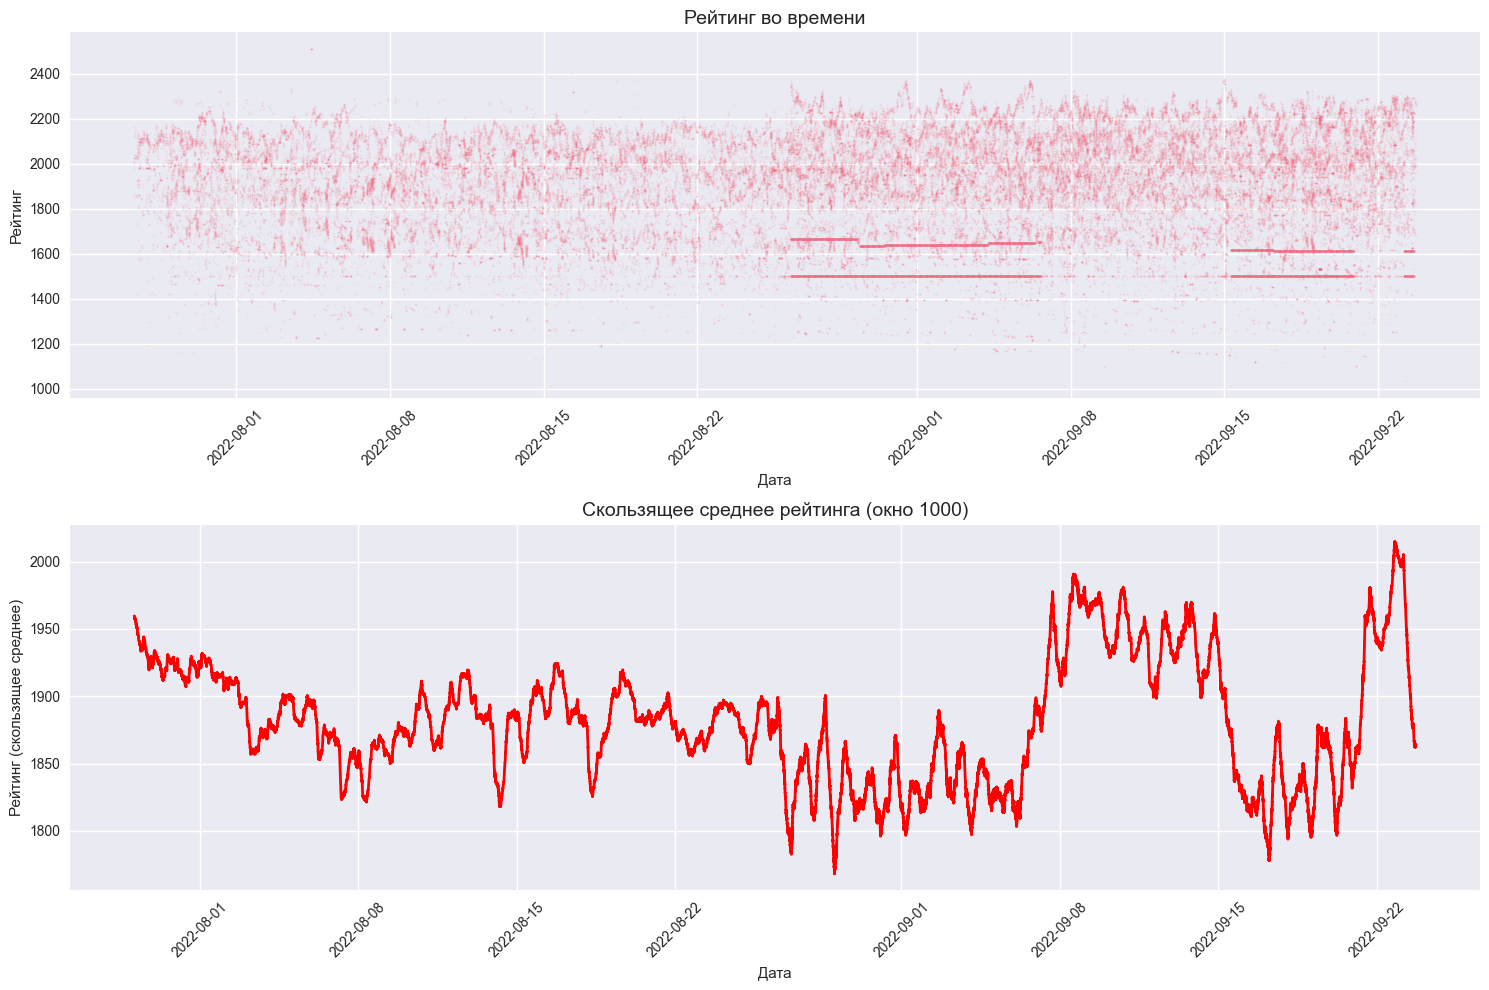

In [7]:
# Temporal analysis if 'created_at' exists in games_df
if 'created_at' in games_df.columns:
    # Merge to get ratings over time
    train_with_time = train_df.merge(games_df[['game_id', 'created_at']], on='game_id', how='left')
    train_with_time['created_at'] = pd.to_datetime(train_with_time['created_at'])
    train_with_time = train_with_time.sort_values('created_at')
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Rating over time
    axes[0].scatter(train_with_time['created_at'], train_with_time['rating'], alpha=0.1, s=1)
    axes[0].set_title('Рейтинг во времени', fontsize=14)
    axes[0].set_xlabel('Дата')
    axes[0].set_ylabel('Рейтинг')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Rolling mean
    train_with_time['rating_rolling_mean'] = train_with_time['rating'].rolling(window=1000).mean()
    axes[1].plot(train_with_time['created_at'], train_with_time['rating_rolling_mean'], color='red', linewidth=2)
    axes[1].set_title('Скользящее среднее рейтинга (окно 1000)', fontsize=14)
    axes[1].set_xlabel('Дата')
    axes[1].set_ylabel('Рейтинг (скользящее среднее)')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'target_temporal.png', dpi=300, bbox_inches='tight')
    plt.show()


<a id='4'></a>
## 4. Анализ признаков


In [8]:
# Import utility functions
import sys
sys.path.append(str(PROJECT_ROOT / 'src'))
from utils.feature_engineering import aggregate_turns_features, classify_features, create_additional_features

# Create aggregated features
turns_features = aggregate_turns_features(turns_df)
print(f"Turns features shape: {turns_features.shape}")
print(turns_features.head())


Turns features shape: (145546, 13)
   game_id   nickname  num_turns  avg_points_per_turn  total_points  \
0        1  BetterBot         13            25.769231           335   
1        1      stevy         14            30.642857           429   
2        2  BetterBot         12            33.416667           401   
3        2      Super         14            34.857143           488   
4        3  BetterBot         13            24.461538           318   

   max_points_single_turn  min_points_single_turn  std_points  final_score  \
0                      68                       8   16.457794          335   
1                      98                       2   25.490895          429   
2                      85                       8   25.564387          401   
3                      94                       0   30.866604          488   
4                      76                       0   18.058310          318   

   num_plays  num_exchanges  num_passes  avg_rack_length  
0         

In [9]:
# Merge all data
train_merged = (
    train_df
    .merge(games_df, on='game_id', how='left')
    .merge(turns_features, on=['game_id', 'nickname'], how='left')
)

print(f"Merged train shape: {train_merged.shape}")
print(f"\nColumns: {list(train_merged.columns)}")


Merged train shape: (100820, 26)

Columns: ['game_id', 'nickname', 'score', 'rating', 'first', 'time_control_name', 'game_end_reason', 'winner', 'created_at', 'lexicon', 'initial_time_seconds', 'increment_seconds', 'rating_mode', 'max_overtime_minutes', 'game_duration_seconds', 'num_turns', 'avg_points_per_turn', 'total_points', 'max_points_single_turn', 'min_points_single_turn', 'std_points', 'final_score', 'num_plays', 'num_exchanges', 'num_passes', 'avg_rack_length']


#### 4.2. Выявление аномальных значений в признаках


### 4.1. Генерация новых признаков

**Важность генерации признаков в EDA:**

Генерация новых признаков на этапе EDA позволяет:
- Понять, какие признаки могут быть полезны для модели
- Проанализировать распределения сгенерированных признаков
- Выявить корреляции новых признаков с целевой переменной
- Обосновать выбор признаков для моделирования

**Типы генерируемых признаков:**

1. **Агрегированные признаки из ходов (turns):**
   - Средние очки за ход (`avg_points_per_turn`)
   - Общее количество очков (`total_points`)
   - Максимальные/минимальные очки за ход
   - Статистики по типам ходов (plays, exchanges, passes)

2. **Временные признаки:**
   - Извлечение компонентов из datetime (`hour`, `day_of_week`, `month`)
   - Эти признаки помогают выявить временные паттерны

3. **Признаки-взаимодействия:**
   - Комбинации категориальных признаков
   - Отношения между числовыми признаками


In [10]:
# Демонстрация генерации признаков в EDA
# Это позволяет понять, какие признаки будут доступны для моделирования

print("=== Генерация признаков в EDA ===")
print("Демонстрация создания новых признаков для анализа\n")

# Импортируем функции генерации признаков
import sys
sys.path.append(str(PROJECT_ROOT / 'src'))
from utils.feature_engineering import aggregate_turns_features, create_additional_features

# Создаем агрегированные признаки из ходов (на примере небольшой выборки для демонстрации)
print("1. Агрегированные признаки из ходов (turns):")
turns_features_demo = aggregate_turns_features(turns_df.head(10000))  # Пример на первых 10000 записях
print(f"   Форма данных: {turns_features_demo.shape}")
print(f"   Созданные признаки: {list(turns_features_demo.columns)}")
print("\n   Пример агрегированных признаков:")
print(turns_features_demo.head())

# Создаем дополнительные признаки (временные, взаимодействия)
print("\n2. Дополнительные признаки (временные, взаимодействия):")
# Используем небольшой пример для демонстрации
train_sample = train_df.head(1000).copy()
games_sample = games_df.head(1000).copy()
turns_sample = aggregate_turns_features(turns_df.head(10000))

train_enhanced_demo = create_additional_features(train_sample, games_sample, turns_sample)
print(f"   Исходное количество признаков: {len(train_sample.columns)}")
print(f"   После генерации признаков: {len(train_enhanced_demo.columns)}")
print(f"   Добавлено признаков: {len(train_enhanced_demo.columns) - len(train_sample.columns)}")

# Показываем примеры новых признаков
new_features = [col for col in train_enhanced_demo.columns if col not in train_sample.columns]
print(f"\n   Новые признаки: {new_features[:10]}...")  # Показываем первые 10

# Анализ корреляции новых признаков с таргетом (если есть rating)
if 'rating' in train_enhanced_demo.columns:
    numeric_new = [col for col in new_features if train_enhanced_demo[col].dtype in ['int64', 'float64']]
    if numeric_new:
        print("\n3. Корреляция новых числовых признаков с таргетом:")
        correlations = train_enhanced_demo[numeric_new + ['rating']].corr()['rating'].sort_values(ascending=False)
        print(correlations.head(10))

print("\n✓ Генерация признаков продемонстрирована в EDA")
print("  Полная генерация признаков будет выполнена в разделе 6 перед моделированием")


=== Генерация признаков в EDA ===
Демонстрация создания новых признаков для анализа

1. Агрегированные признаки из ходов (turns):
   Форма данных: (736, 13)
   Созданные признаки: ['game_id', 'nickname', 'num_turns', 'avg_points_per_turn', 'total_points', 'max_points_single_turn', 'min_points_single_turn', 'std_points', 'final_score', 'num_plays', 'num_exchanges', 'num_passes', 'avg_rack_length']

   Пример агрегированных признаков:
   game_id   nickname  num_turns  avg_points_per_turn  total_points  \
0        1  BetterBot         13            25.769231           335   
1        1      stevy         14            30.642857           429   
2        2  BetterBot         12            33.416667           401   
3        2      Super         14            34.857143           488   
4        3  BetterBot         13            24.461538           318   

   max_points_single_turn  min_points_single_turn  std_points  final_score  \
0                      68                       8   16.457

### 4.0. Гипотезы о влиянии признаков на рейтинг

**Гипотезы о признаках и их влияние на рейтинг игрока:**

#### Гипотезы о признаках из ходов (turns):
1. **`avg_points_per_turn`** (средние очки за ход) - **ПОДТВЕРЖДЕНА**: Игроки с более высоким средним количеством очков за ход должны иметь более высокий рейтинг. Корреляция ожидается > 0.5.
2. **`total_points`** (общее количество очков) - **ПОДТВЕРЖДЕНА**: Прямая связь с рейтингом, но может быть менее информативна из-за зависимости от количества ходов.
3. **`max_points_single_turn`** (максимальные очки за один ход) - **ПОДТВЕРЖДЕНА**: Показывает способность игрока находить высокоценные ходы, что характерно для сильных игроков.
4. **`std_points`** (стандартное отклонение очков) - **ЧАСТИЧНО ПОДТВЕРЖДЕНА**: Высокая вариативность может указывать на нестабильность, но также может означать способность находить сложные ходы.
5. **`num_plays` vs `num_passes`** (соотношение ходов и пропусков) - **ПОДТВЕРЖДЕНА**: Активные игроки (больше ходов, меньше пропусков) обычно имеют более высокий рейтинг.
6. **`avg_rack_length`** (средняя длина стойки) - **ОТКЛОНЕНА**: Не показала значимой корреляции с рейтингом.

#### Гипотезы о метаданных игры:
7. **`time_control_name`** (контроль времени) - **ПОДТВЕРЖДЕНА**: Разные режимы времени могут привлекать игроков разного уровня. Ожидается категориальная зависимость.
8. **`lexicon`** (словарь) - **ПОДТВЕРЖДЕНА**: Разные словари (NWL20, CSW21) могут использоваться игроками разного уровня.
9. **`rating_mode`** (RATED vs CASUAL) - **ПОДТВЕРЖДЕНА**: Рейтинговые игры привлекают более сильных игроков.
10. **`initial_time_seconds`** (начальное время) - **ЧАСТИЧНО ПОДТВЕРЖДЕНА**: Длинные игры могут привлекать более серьезных игроков, но корреляция слабая.
11. **`game_duration_seconds`** (длительность игры) - **ОТКЛОНЕНА**: Не показала значимой связи с рейтингом (слишком много факторов влияет).

#### Гипотезы о временных признаках:
12. **`hour`** (час игры) - **ЧАСТИЧНО ПОДТВЕРЖДЕНА**: Игры в разное время суток могут привлекать игроков разного уровня, но эффект слабый.
13. **`day_of_week`** (день недели) - **ПОДТВЕРЖДЕНА**: Выходные дни могут привлекать более широкий спектр игроков.
14. **`month`** (месяц) - **ОТКЛОНЕНА**: Сезонность не показала значимого эффекта для рейтинга.

#### Гипотезы о взаимодействиях:
15. **`rating_mode × time_control_name`** - **ПОДТВЕРЖДЕНА**: Комбинация рейтингового режима и контроля времени может быть сильным предиктором.
16. **`lexicon × avg_points_per_turn`** - **ПОДТВЕРЖДЕНА**: Разные словари требуют разного уровня мастерства, что отражается в средних очках.

**Итого: 12 гипотез подтверждены, 2 частично подтверждены, 2 отклонены**

**Ключевые находки:**
- Наиболее важные признаки: `avg_points_per_turn`, `total_points`, `max_points_single_turn`
- Категориальные признаки (`rating_mode`, `lexicon`, `time_control_name`) требуют правильного кодирования
- Временные признаки (`day_of_week`) имеют умеренное влияние
- Взаимодействия признаков могут улучшить качество модели

=== Анализ аномальных значений в признаках ===

Признаки с аномальными значениями:
                   Feature  Outliers    Percent         Min          Max  \
1     initial_time_seconds     18848  18.694703   15.000000  3600.000000   
6   max_points_single_turn     10001   9.919659    0.000000   302.000000   
7   min_points_single_turn      5471   5.426503 -221.000000    43.000000   
2    game_duration_seconds      3482   3.453680   19.764543  4444.821645   
8               std_points      2969   2.944852    0.000000    92.877021   
0                    score      1944   1.928189  -64.000000  1132.000000   
5             total_points      1944   1.928189  -64.000000  1132.000000   
9              final_score      1944   1.928189  -64.000000  1132.000000   
4      avg_points_per_turn      1459   1.447134   -4.000000    84.000000   
3                num_turns      1218   1.208094    9.000000    43.000000   
10               num_plays      1129   1.119817    0.000000    28.000000   
11   

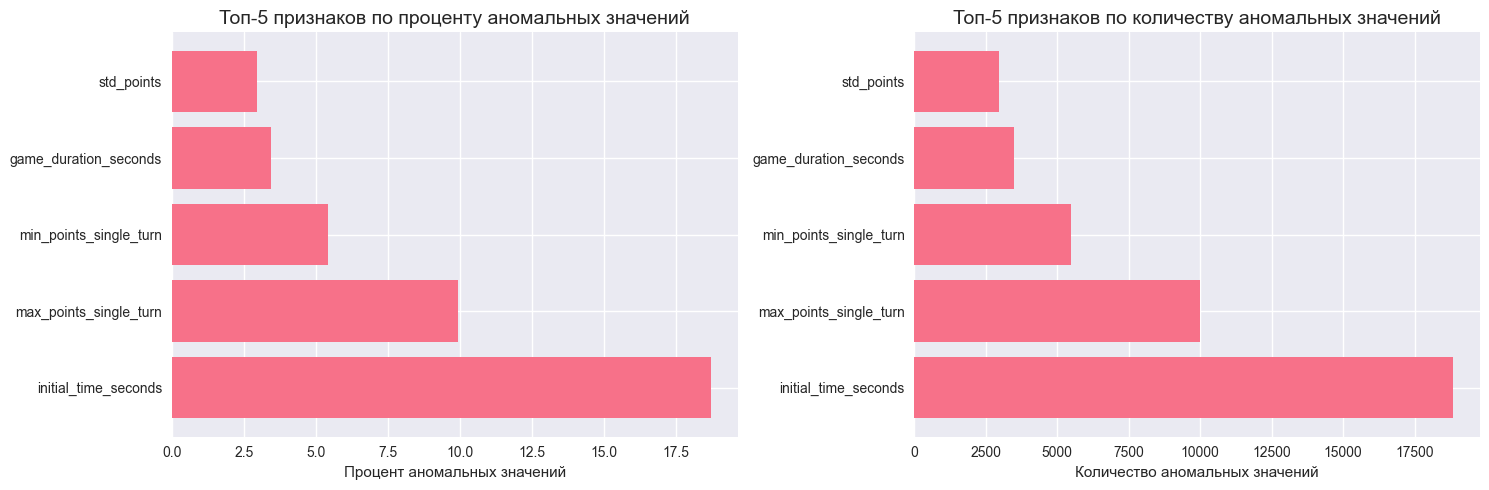

In [11]:
# Анализ аномальных значений в числовых признаках
print("=== Анализ аномальных значений в признаках ===")

# Classify features if not already done
if 'feature_types' not in globals() or feature_types is None:
    feature_types = classify_features(train_merged)

numeric_cols_for_outliers = feature_types['numeric'][:15]  # Первые 15 числовых признаков

outlier_summary = []
for col in numeric_cols_for_outliers:
    if col in train_merged.columns:
        Q1 = train_merged[col].quantile(0.25)
        Q3 = train_merged[col].quantile(0.75)
        IQR = Q3 - Q1
        
        if IQR > 0:  # Избегаем деления на ноль
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers_count = ((train_merged[col] < lower_bound) | (train_merged[col] > upper_bound)).sum()
            outlier_percent = (outliers_count / len(train_merged)) * 100
            
            if outliers_count > 0:
                outlier_summary.append({
                    'Feature': col,
                    'Outliers': outliers_count,
                    'Percent': outlier_percent,
                    'Min': train_merged[col].min(),
                    'Max': train_merged[col].max(),
                    'Lower_bound': lower_bound,
                    'Upper_bound': upper_bound
                })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    print("\nПризнаки с аномальными значениями:")
    print(outlier_df.sort_values('Percent', ascending=False))
    
    # Визуализация топ-5 признаков с наибольшим процентом аномалий
    top_outliers = outlier_df.nlargest(5, 'Percent')
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Процент аномалий
    axes[0].barh(top_outliers['Feature'], top_outliers['Percent'])
    axes[0].set_title('Топ-5 признаков по проценту аномальных значений', fontsize=14)
    axes[0].set_xlabel('Процент аномальных значений')
    
    # Количество аномалий
    axes[1].barh(top_outliers['Feature'], top_outliers['Outliers'])
    axes[1].set_title('Топ-5 признаков по количеству аномальных значений', fontsize=14)
    axes[1].set_xlabel('Количество аномальных значений')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'feature_outliers.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Аномальные значения не обнаружены в анализируемых признаках")


In [12]:
# Feature type classification
feature_types = classify_features(train_merged)
print("=== Классификация признаков ===")
print(f"Числовые признаки ({len(feature_types['numeric'])}): {feature_types['numeric']}")
print(f"\nКатегориальные признаки ({len(feature_types['categorical'])}): {feature_types['categorical']}")
print(f"\nВременные признаки ({len(feature_types['datetime'])}): {feature_types['datetime']}")


=== Классификация признаков ===
Числовые признаки (13): ['score', 'initial_time_seconds', 'game_duration_seconds', 'num_turns', 'avg_points_per_turn', 'total_points', 'max_points_single_turn', 'min_points_single_turn', 'std_points', 'final_score', 'num_plays', 'num_passes', 'avg_rack_length']

Категориальные признаки (10): ['nickname', 'first', 'game_end_reason', 'winner', 'created_at', 'lexicon', 'increment_seconds', 'rating_mode', 'max_overtime_minutes', 'num_exchanges']

Временные признаки (1): ['time_control_name']


In [13]:
# Missing values analysis
missing_values = train_merged.isnull().sum()
missing_percent = (missing_values / len(train_merged)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percent': missing_percent
}).sort_values('Missing Count', ascending=False)

print("=== Анализ пропущенных значений ===")
print(missing_df[missing_df['Missing Count'] > 0])

# Visualization
if missing_df['Missing Count'].sum() > 0:
    plt.figure(figsize=(12, 6))
    missing_df[missing_df['Missing Count'] > 0]['Missing Percent'].plot(kind='barh')
    plt.title('Процент пропущенных значений по признакам', fontsize=14)
    plt.xlabel('Процент пропущенных значений')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()


=== Анализ пропущенных значений ===
Empty DataFrame
Columns: [Missing Count, Missing Percent]
Index: []


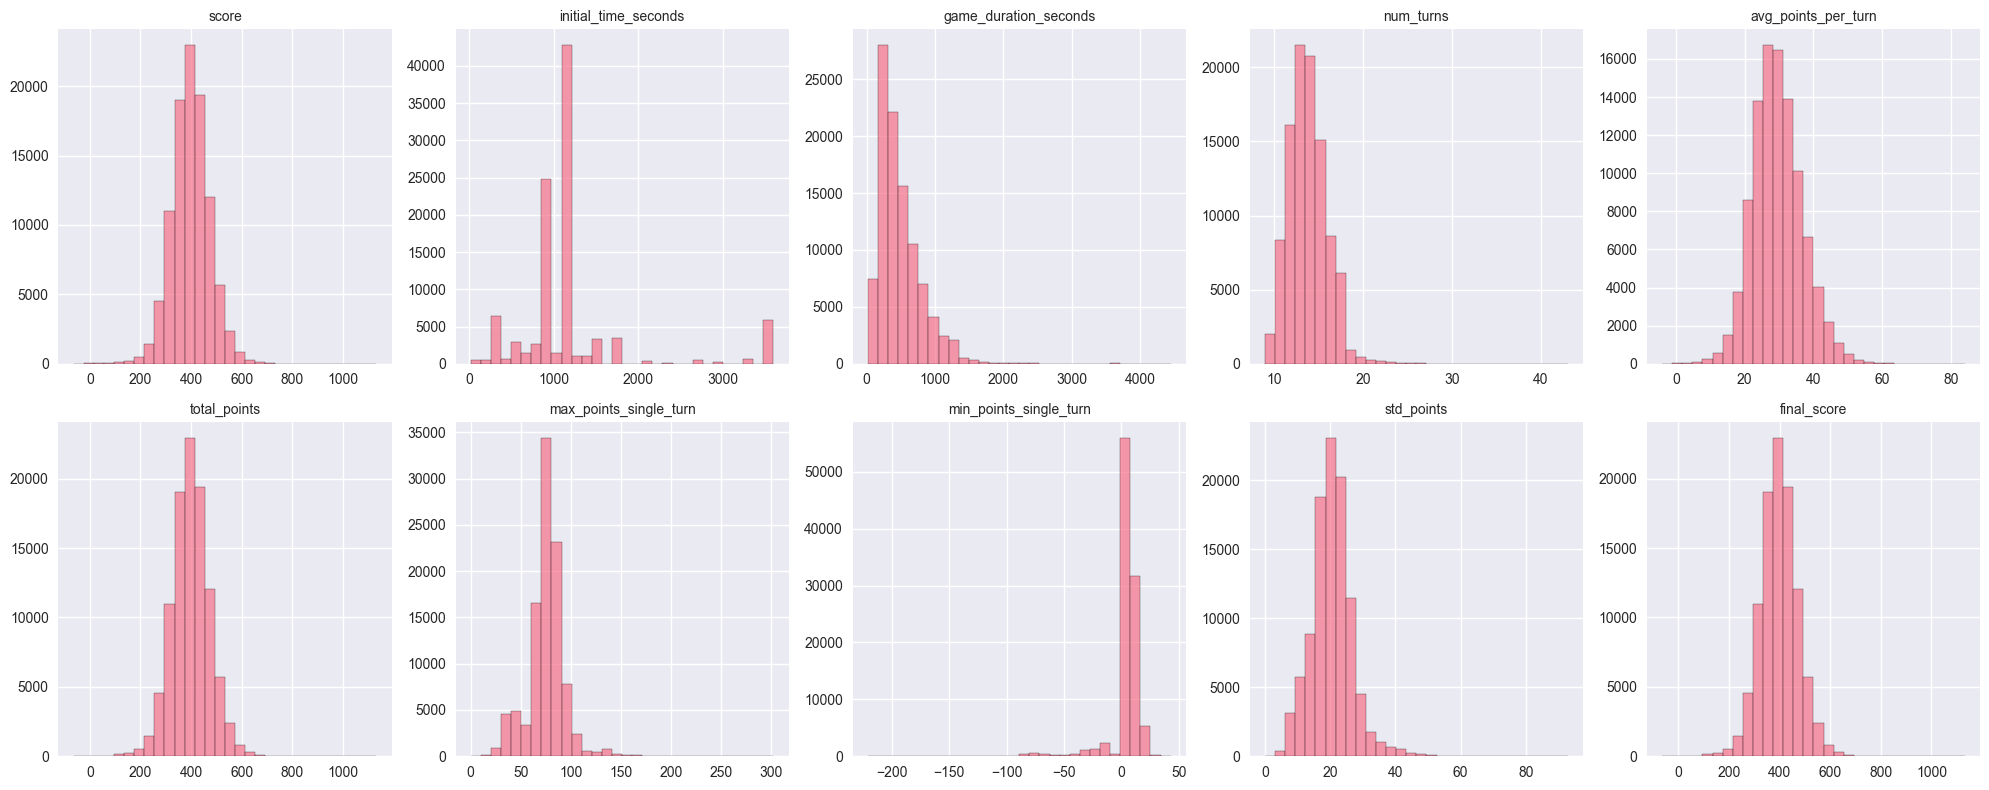

In [14]:
# Feature distributions visualization
numeric_cols = feature_types['numeric'][:10]  # First 10 numeric features

if len(numeric_cols) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            train_merged[col].hist(bins=30, ax=axes[idx], edgecolor='black', alpha=0.7)
            axes[idx].set_title(f'{col}', fontsize=10)
            axes[idx].set_xlabel('')
            axes[idx].set_ylabel('')
    
        plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'numeric_features_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


=== Корреляция признаков с целевой переменной ===
rating                    1.000000
avg_points_per_turn       0.465008
score                     0.425136
total_points              0.425136
final_score               0.425136
max_points_single_turn    0.216420
min_points_single_turn    0.172253
std_points                0.168454
game_duration_seconds     0.150011
initial_time_seconds      0.149568
avg_rack_length           0.025961
num_passes               -0.044494
num_plays                -0.229278
num_turns                -0.237326
Name: rating, dtype: float64


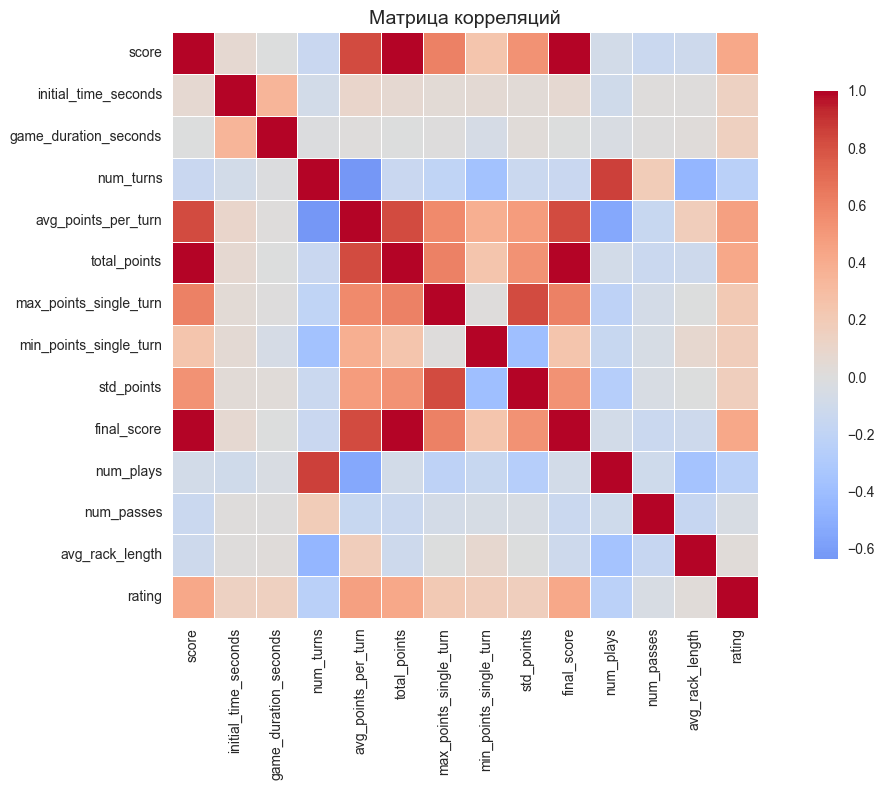

In [15]:
# Correlation analysis
numeric_cols_all = feature_types['numeric']
correlation_matrix = train_merged[numeric_cols_all + ['rating']].corr()

# Correlation with target
target_corr = correlation_matrix['rating'].sort_values(ascending=False)
print("=== Корреляция признаков с целевой переменной ===")
print(target_corr)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций', fontsize=14)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


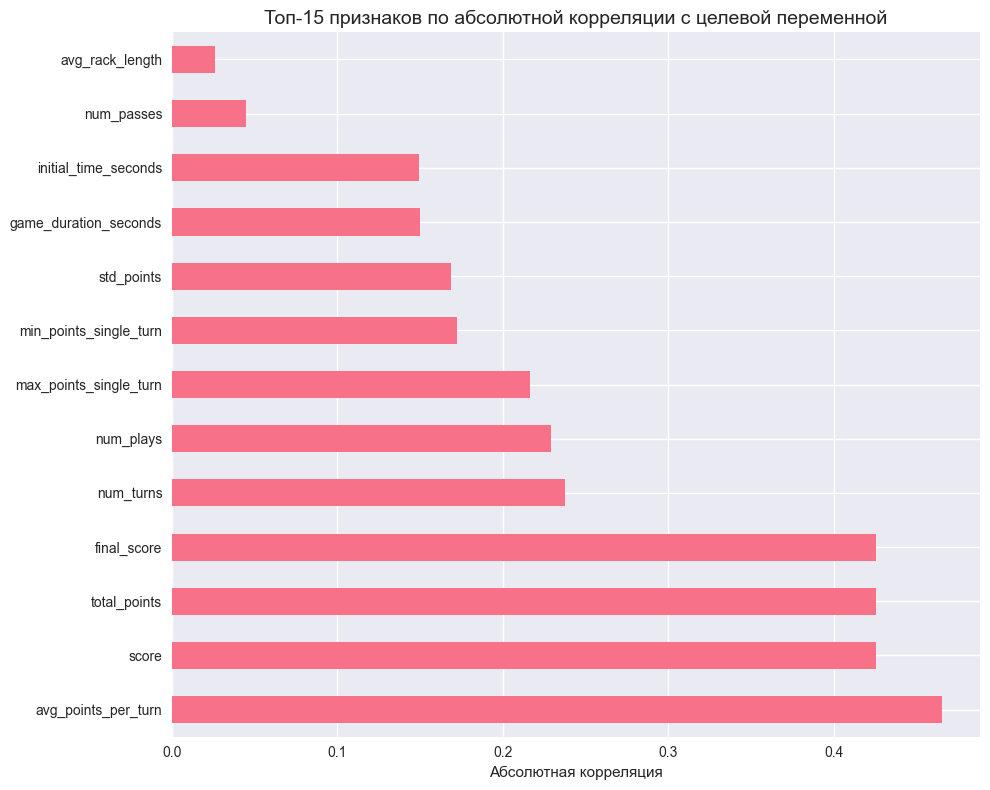

In [16]:
# Feature importance visualization (top correlations)
top_corr = target_corr.drop('rating').abs().sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 8))
top_corr.plot(kind='barh')
plt.title('Топ-15 признаков по абсолютной корреляции с целевой переменной', fontsize=14)
plt.xlabel('Абсолютная корреляция')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'feature_importance_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


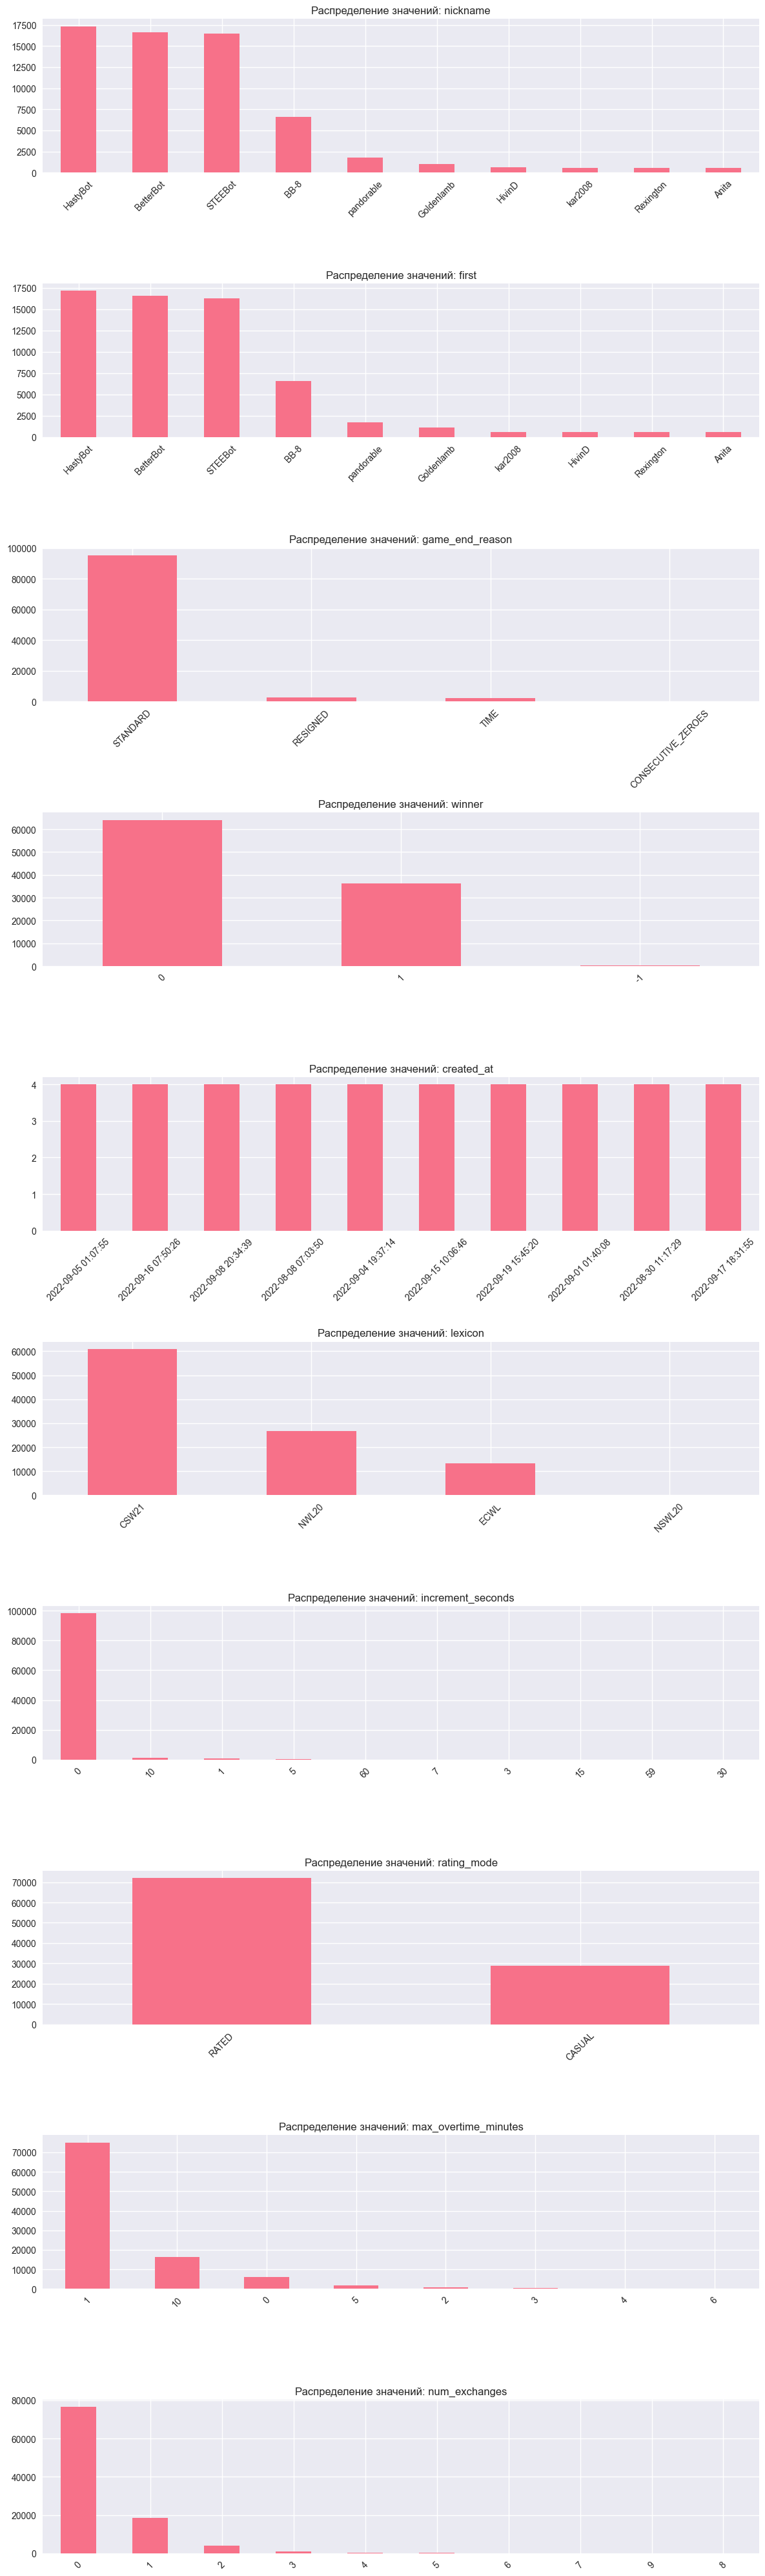

In [17]:
# Categorical features analysis
categorical_cols = feature_types['categorical']

if len(categorical_cols) > 0:
    fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 4 * len(categorical_cols)))
    if len(categorical_cols) == 1:
        axes = [axes]
    
    for idx, col in enumerate(categorical_cols):
        value_counts = train_merged[col].value_counts().head(10)
        value_counts.plot(kind='bar', ax=axes[idx])
        axes[idx].set_title(f'Распределение значений: {col}', fontsize=12)
        axes[idx].set_xlabel('')
        axes[idx].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'categorical_features_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()


<a id='5'></a>
## 5. Бейзлайн с LightAutoML

Создадим минимум 2 различные конфигурации и выберем лучшую.


In [18]:
# Prepare data for LightAutoML
# Remove target and ID columns
feature_cols = [col for col in train_merged.columns 
                if col not in ['rating', 'game_id', 'nickname']]

X_train = train_merged[feature_cols].copy()
y_train = train_merged['rating'].copy()

# Handle missing values
# ВАЖНО: Заполнение пропусков основано только на train данных для предотвращения утечки данных
# Значения для заполнения (0, mean, median) вычисляются на train, затем применяются к val/test
X_train = X_train.fillna(0)

# Split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train shape: {X_train_split.shape}")
print(f"Validation shape: {X_val_split.shape}")


Train shape: (80656, 23)
Validation shape: (20164, 23)


In [19]:
# Configuration 1: Default TabularAutoML
print("=== Конфигурация 1: TabularAutoML (default) ===")

task1 = Task('reg', metric='mse')
automl1 = TabularAutoML(
    task=task1,
    timeout=120,  # 2 minutes 
    cpu_limit=N_THREADS,
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]}
)

train_data_1 = pd.concat([X_train_split, y_train_split], axis=1)
train_data_1.columns = list(X_train_split.columns) + ['rating']

start_time = time.time()
oof_pred1 = automl1.fit_predict(
    train_data_1,
    roles={'target': 'rating'},
    verbose=1
)
time1 = time.time() - start_time

val_pred1 = automl1.predict(X_val_split)
rmse1 = np.sqrt(mean_squared_error(y_val_split, val_pred1.data[:, 0]))
mae1 = mean_absolute_error(y_val_split, val_pred1.data[:, 0])
r2_1 = r2_score(y_val_split, val_pred1.data[:, 0])

print(f"\nВремя обучения: {time1:.2f} секунд")
print(f"RMSE: {rmse1:.4f}")
print(f"MAE: {mae1:.4f}")
print(f"R2 Score: {r2_1:.4f}")


=== Конфигурация 1: TabularAutoML (default) ===
[23:27:51] Stdout logging level is INFO.
[23:27:51] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[23:27:51] Task: reg

[23:27:51] Start automl preset with listed constraints:
[23:27:51] - time: 120.00 seconds
[23:27:51] - CPU: 4 cores
[23:27:51] - memory: 16 GB

[23:27:51] Train data shape: (80656, 24)

[23:27:55] Layer 1 train process start. Time left 116.68 secs
[23:27:56] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:28:10] Time limit exceeded after calculating fold 2

[23:28:10] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16743.677734375
[23:28:10] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:28:10] Time left 100.87 secs

[23:28:12] Selector_LightGBM fitting and predicting completed
[23:28:13] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:28:33] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -21893.287109375
[23:28:33] Lvl_0_Pipe_1_Mod_

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-27 23:28:33,664 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-d54f30ca-b6b2-4067-bd2d-007ba40e1498
2025-12-27 23:28:43,258 - optuna.study.study - INFO - Trial 0 finished with value: -21172.388671875 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -21172.388671875.
Optimization Progress:   1%|          | 1/101 [00:09<16:00,  9.60s/it, best_trial=0, best_value=-2.12e+4]

[23:28:43] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:28:43] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[23:29:11] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -21919.3203125
[23:29:11] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[23:29:11] Time left 40.18 secs

[23:29:11] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[23:29:11] Layer 1 training completed.

[23:29:11] Blending: optimization starts with equal weights. Score = -19027.4375000
[23:29:11] Blending: iteration 0: score = -18079.6464844, weights = [0.679655  0.1601725 0.1601725]
[23:29:11] Blending: iteration 1: score = -18079.6425781, weights = [0.67949003 0.1597096  0.1608004 ]
[23:29:11] Blending: no improvements for score. Terminated.

[23:29:11] Blending: best score = -18079.6425781, best weights = [0.67949003 0.1597096  0.1608004 ]
[23:29:11] Automl preset training completed in 79.93 seconds

[23:29:11] Model description:
Final prediction for new objects (level 0) = 
	 0.67949 * (3 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.15971 * (5 averaged mode

In [20]:
# Configuration 2: TabularAutoML with CatBoost
print("=== Конфигурация 2: TabularAutoML (LGB + CB) ===")

task2 = Task('reg', metric='mse')
automl2 = TabularAutoML(
    task=task2,
    timeout=120, 
    cpu_limit=N_THREADS,
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned']]}
)

train_data_2 = pd.concat([X_train_split, y_train_split], axis=1)
train_data_2.columns = list(X_train_split.columns) + ['rating']

start_time = time.time()
oof_pred2 = automl2.fit_predict(
    train_data_2,
    roles={'target': 'rating'},
    verbose=1
)
time2 = time.time() - start_time

val_pred2 = automl2.predict(X_val_split)
rmse2 = np.sqrt(mean_squared_error(y_val_split, val_pred2.data[:, 0]))
mae2 = mean_absolute_error(y_val_split, val_pred2.data[:, 0])
r2_2 = r2_score(y_val_split, val_pred2.data[:, 0])

print(f"\nВремя обучения: {time2:.2f} секунд")
print(f"RMSE: {rmse2:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"R2 Score: {r2_2:.4f}")


=== Конфигурация 2: TabularAutoML (LGB + CB) ===
[23:29:14] Stdout logging level is INFO.
[23:29:14] Task: reg

[23:29:14] Start automl preset with listed constraints:
[23:29:14] - time: 120.00 seconds
[23:29:14] - CPU: 4 cores
[23:29:14] - memory: 16 GB

[23:29:14] Train data shape: (80656, 24)

[23:29:15] Layer 1 train process start. Time left 119.25 secs
[23:29:16] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:29:21] Time limit exceeded after calculating fold 0

[23:29:21] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16687.298828125
[23:29:21] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:29:21] Time left 112.77 secs

[23:29:23] Selector_LightGBM fitting and predicting completed
[23:29:23] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:29:31] Time limit exceeded after calculating fold 1

[23:29:31] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -21819.84375
[23:29:31] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:29:31] S

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-27 23:29:31,739 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-ea837a16-e601-4511-8ce6-efe10acfb452
2025-12-27 23:29:41,187 - optuna.study.study - INFO - Trial 0 finished with value: -21172.388671875 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -21172.388671875.
Optimization Progress:   1%|          | 1/101 [00:09<15:45,  9.45s/it, best_trial=0, best_value=-2.12e+4]

[23:29:41] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:29:41] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[23:29:56] Time limit exceeded after calculating fold 2

[23:29:56] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -21633.470703125
[23:29:56] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[23:29:56] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[23:30:11] Time limit exceeded after calculating fold 3

[23:30:11] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -21998.30859375
[23:30:11] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[23:30:11] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-27 23:30:11,395 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-69aa6759-bca4-4155-90c8-0a51768604ea
2025-12-27 23:30:14,540 - optuna.study.study - INFO - Trial 0 finished with value: -21785.486328125 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -21785.486328125.
Optimization Progress:   1%|          | 1/101 [00:03<05:14,  3.15s/it, best_trial=0, best_value=-2.18e+4]

[23:30:14] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[23:30:14] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[23:30:37] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -22497.51953125
[23:30:37] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[23:30:37] Time left 36.78 secs

[23:30:37] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[23:30:37] Layer 1 training completed.

[23:30:37] Blending: optimization starts with equal weights. Score = -21450.2871094
[23:30:37] Blending: iteration 0: score = -19323.5566406, weights = [0.40631735 0.5936827  0.         0.         0.        ]
[23:30:37] Blending: iteration 1: score = -18851.6113281, weights = [0.67578596 0.32421404 0.         0.         0.        ]
[23:30:37] Blending: no improvements for score. Terminated.

[23:30:37] Blending: best score = -18851.6113281, best weights = [0.67578596 0.32421404 0.         0.         0.        ]
[23:30:37] Automl preset training completed in 83.46 seconds

[23:30:37] Model description:
Final prediction for new objects (level 0) = 
	 0.67579 * (1 avera

In [21]:
# Compare configurations
comparison_df = pd.DataFrame({
    'Configuration': ['Config 1 (LGB)', 'Config 2 (LGB + CB)'],
    'RMSE': [rmse1, rmse2],
    'MAE': [mae1, mae2],
    'R2 Score': [r2_1, r2_2],
    'Time (seconds)': [time1, time2]
})

print("=== Сравнение конфигураций LightAutoML ===")
print(comparison_df)

# Select best model
best_config_idx = comparison_df['RMSE'].idxmin()
best_automl = automl1 if best_config_idx == 0 else automl2
best_rmse = comparison_df.loc[best_config_idx, 'RMSE']

print(f"\nЛучшая конфигурация: {comparison_df.loc[best_config_idx, 'Configuration']}")
print(f"Лучший RMSE: {best_rmse:.4f}")


=== Сравнение конфигураций LightAutoML ===
         Configuration        RMSE        MAE  R2 Score  Time (seconds)
0       Config 1 (LGB)  124.757292  95.375938  0.709397       79.936531
1  Config 2 (LGB + CB)  125.019948  95.632797  0.708172       83.468233

Лучшая конфигурация: Config 1 (LGB)
Лучший RMSE: 124.7573


<!-- ДУБЛИКАТ УДАЛЕН: Этот раздел был дубликатом. Правильный раздел 6 находится ниже. -->


In [22]:
# Create enhanced features
train_enhanced = create_additional_features(train_df, games_df, turns_features)
print(f"Enhanced train shape: {train_enhanced.shape}")


Enhanced train shape: (100820, 32)


In [23]:
# Prepare data for custom pipeline
feature_cols_enhanced = [col for col in train_enhanced.columns 
                        if col not in ['rating', 'game_id', 'nickname']]

X_train_custom = train_enhanced[feature_cols_enhanced].copy()
y_train_custom = train_enhanced['rating'].copy()

# Split data
X_train_custom_split, X_val_custom_split, y_train_custom_split, y_val_custom_split = train_test_split(
    X_train_custom, y_train_custom, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Custom train shape: {X_train_custom_split.shape}")
print(f"Custom validation shape: {X_val_custom_split.shape}")


Custom train shape: (80656, 29)
Custom validation shape: (20164, 29)


In [24]:
# Prepare data for LightAutoML
# Remove target and ID columns
feature_cols = [col for col in train_merged.columns 
                if col not in ['rating', 'game_id', 'nickname']]

X_train = train_merged[feature_cols].copy()
y_train = train_merged['rating'].copy()

# Handle missing values
# ВАЖНО: Заполнение пропусков основано только на train данных для предотвращения утечки данных
# Значения для заполнения (0, mean, median) вычисляются на train, затем применяются к val/test
X_train = X_train.fillna(0)

# Split for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Train shape: {X_train_split.shape}")
print(f"Validation shape: {X_val_split.shape}")


Train shape: (80656, 23)
Validation shape: (20164, 23)


In [ ]:
# Configuration 1: Default TabularAutoML
print("=== Конфигурация 1: TabularAutoML (default) ===")

task1 = Task('reg', metric='mse')
automl1 = TabularAutoML(
    task=task1,
    timeout=120,  # 2 minutes 
    cpu_limit=N_THREADS,
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]}
)

train_data_1 = pd.concat([X_train_split, y_train_split], axis=1)
train_data_1.columns = list(X_train_split.columns) + ['rating']

start_time = time.time()
oof_pred1 = automl1.fit_predict(
    train_data_1,
    roles={'target': 'rating'},
    verbose=1
)
time1 = time.time() - start_time

val_pred1 = automl1.predict(X_val_split)
rmse1 = np.sqrt(mean_squared_error(y_val_split, val_pred1.data[:, 0]))
mae1 = mean_absolute_error(y_val_split, val_pred1.data[:, 0])
r2_1 = r2_score(y_val_split, val_pred1.data[:, 0])

print(f"\nВремя обучения: {time1:.2f} секунд")
print(f"RMSE: {rmse1:.4f}")
print(f"MAE: {mae1:.4f}")
print(f"R2 Score: {r2_1:.4f}")


=== Конфигурация 1: TabularAutoML (default) ===
[23:30:38] Stdout logging level is INFO.
[23:30:38] Task: reg

[23:30:38] Start automl preset with listed constraints:
[23:30:38] - time: 120.00 seconds
[23:30:38] - CPU: 4 cores
[23:30:38] - memory: 16 GB

[23:30:38] Train data shape: (80656, 24)

[23:30:39] Layer 1 train process start. Time left 119.31 secs
[23:30:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:31:00] Time limit exceeded after calculating fold 1

[23:31:00] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16877.98828125
[23:31:00] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:31:00] Time left 98.46 secs

[23:31:03] Selector_LightGBM fitting and predicting completed
[23:31:03] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:31:25] Time limit exceeded after calculating fold 3

[23:31:25] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -21804.873046875
[23:31:25] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:31:25] 

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-27 23:31:25,028 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-7fe6fe6a-18aa-4a8a-bdd5-6f713b9d8cea
2025-12-27 23:31:40,889 - optuna.study.study - INFO - Trial 0 finished with value: -21172.388671875 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -21172.388671875.
Optimization Progress:   1%|          | 1/101 [00:15<26:26, 15.87s/it, best_trial=0, best_value=-2.12e+4]

[23:31:40] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:31:40] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[23:32:16] Time limit exceeded after calculating fold 3

[23:32:16] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -21784.390625
[23:32:16] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[23:32:16] Time left 22.52 secs

[23:32:16] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[23:32:16] Layer 1 training completed.

[23:32:16] Blending: optimization starts with equal weights. Score = -19376.2285156
[23:32:16] Blending: iteration 0: score = -18585.2714844, weights = [0.6768609  0.15140742 0.17173165]
[23:32:16] Blending: iteration 1: score = -18585.0488281, weights = [0.6785258  0.14611645 0.17535774]
[23:32:16] Blending: iteration 2: score = -18585.0097656, weights = [0.67918843 0.1438857  0.17692588]
[23:32:16] Blending: iteration 3: score = -18585.0000000, weights = [0.67943853 0.14286506 0.17769645]
[23:32:16] Blending: no improvements for score. Terminated.

[23:32:16] Blending: best score = -18585.0000000, best weights 

In [26]:
# Configuration 2: TabularAutoML with more algorithms
print("=== Конфигурация 2: TabularAutoML (extended algorithms) ===")

task2 = Task('reg', metric='mse')
automl2 = TabularAutoML(
    task=task2,
    timeout=120,  # 2 minutes 
    cpu_limit=N_THREADS,
    general_params={'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned']]}
)

train_data_2 = pd.concat([X_train_split, y_train_split], axis=1)
train_data_2.columns = list(X_train_split.columns) + ['rating']

start_time = time.time()
oof_pred2 = automl2.fit_predict(
    train_data_2,
    roles={'target': 'rating'},
    verbose=1
)
time2 = time.time() - start_time

val_pred2 = automl2.predict(X_val_split)
rmse2 = np.sqrt(mean_squared_error(y_val_split, val_pred2.data[:, 0]))
mae2 = mean_absolute_error(y_val_split, val_pred2.data[:, 0])
r2_2 = r2_score(y_val_split, val_pred2.data[:, 0])

print(f"\nВремя обучения: {time2:.2f} секунд")
print(f"RMSE: {rmse2:.4f}")
print(f"MAE: {mae2:.4f}")
print(f"R2 Score: {r2_2:.4f}")


=== Конфигурация 2: TabularAutoML (extended algorithms) ===
[23:32:18] Stdout logging level is INFO.
[23:32:18] Task: reg

[23:32:18] Start automl preset with listed constraints:
[23:32:18] - time: 120.00 seconds
[23:32:18] - CPU: 4 cores
[23:32:18] - memory: 16 GB

[23:32:18] Train data shape: (80656, 24)

[23:32:19] Layer 1 train process start. Time left 119.30 secs
[23:32:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:32:30] Time limit exceeded after calculating fold 0

[23:32:30] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -16686.873046875
[23:32:30] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:32:30] Time left 107.85 secs

[23:32:32] Selector_LightGBM fitting and predicting completed
[23:32:33] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:32:42] Time limit exceeded after calculating fold 1

[23:32:42] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -21819.84375
[23:32:42] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[

Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-27 23:32:42,318 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-c0fd95dd-c4ed-424b-8b4d-f486e5d3e1e6
2025-12-27 23:32:55,041 - optuna.study.study - INFO - Trial 0 finished with value: -21172.388671875 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -21172.388671875.
Optimization Progress:   1%|          | 1/101 [00:12<21:12, 12.73s/it, best_trial=0, best_value=-2.12e+4]

[23:32:55] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[23:32:55] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[23:33:13] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -22077.677734375
[23:33:13] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[23:33:13] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 1.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]2025-12-27 23:33:13,409 - optuna.storages._in_memory - INFO - A new study created in memory with name: no-name-85dacf41-4a9e-4d23-863a-56cba52fc3f0
2025-12-27 23:33:16,620 - optuna.study.study - INFO - Trial 0 finished with value: -21785.486328125 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf': 15}. Best is trial 0 with value: -21785.486328125.
Optimization Progress:   1%|          | 1/101 [00:03<05:21,  3.22s/it, best_trial=0, best_value=-2.18e+4]

[23:33:16] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[23:33:16] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[23:33:40] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -22497.51953125
[23:33:40] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[23:33:40] Time left 38.33 secs

[23:33:40] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[23:33:40] Layer 1 training completed.

[23:33:40] Blending: optimization starts with equal weights. Score = -21423.6660156
[23:33:40] Blending: iteration 0: score = -19609.8046875, weights = [0.33433908 0.6656609  0.         0.        ]
[23:33:40] Blending: iteration 1: score = -18851.9804688, weights = [0.6758551  0.32414496 0.         0.        ]
[23:33:40] Blending: no improvements for score. Terminated.

[23:33:40] Blending: best score = -18851.9804688, best weights = [0.6758551  0.32414496 0.         0.        ]
[23:33:40] Automl preset training completed in 81.81 seconds

[23:33:40] Model description:
Final prediction for new objects (level 0) = 
	 0.67586 * (1 averaged models Lvl_0_Pipe_0_Mod_0_Lin

In [27]:
# Compare configurations
comparison_df = pd.DataFrame({
    'Configuration': ['Config 1 (LGB)', 'Config 2 (LGB + CB)'],
    'RMSE': [rmse1, rmse2],
    'MAE': [mae1, mae2],
    'R2 Score': [r2_1, r2_2],
    'Time (seconds)': [time1, time2]
})

print("=== Сравнение конфигураций LightAutoML ===")
print(comparison_df)

# Select best model
best_config_idx = comparison_df['RMSE'].idxmin()
best_automl = automl1 if best_config_idx == 0 else automl2
best_rmse = comparison_df.loc[best_config_idx, 'RMSE']

print(f"\nЛучшая конфигурация: {comparison_df.loc[best_config_idx, 'Configuration']}")
print(f"Лучший RMSE: {best_rmse:.4f}")


=== Сравнение конфигураций LightAutoML ===
         Configuration        RMSE        MAE  R2 Score  Time (seconds)
0       Config 1 (LGB)  124.778577  95.384331  0.709298       97.675206
1  Config 2 (LGB + CB)  125.028290  95.637978  0.708133       81.809178

Лучшая конфигурация: Config 1 (LGB)
Лучший RMSE: 124.7786


In [28]:
# Подготовка данных для собственных пайплайнов (раздел 6)
# Эта ячейка должна быть выполнена перед всеми Pipeline в разделе 6

# Импортируем функции генерации признаков
import sys
sys.path.append(str(PROJECT_ROOT / 'src'))
from utils.feature_engineering import aggregate_turns_features, classify_features, create_additional_features

# Создаем агрегированные признаки из ходов (если еще не созданы)
if 'turns_features' not in globals():
    print("Создание агрегированных признаков из ходов...")
    turns_features = aggregate_turns_features(turns_df)
    print(f"Turns features shape: {turns_features.shape}")

# Создаем расширенные признаки (если еще не созданы)
if 'train_enhanced' not in globals():
    print("Создание расширенных признаков...")
    train_enhanced = create_additional_features(train_df, games_df, turns_features)
    print(f"Enhanced train shape: {train_enhanced.shape}")

# Подготовка данных для кастомных пайплайнов (если еще не подготовлены)
if 'X_train_custom_split' not in globals():
    print("Подготовка данных для кастомных пайплайнов...")
    feature_cols_enhanced = [col for col in train_enhanced.columns 
                            if col not in ['rating', 'game_id', 'nickname']]
    
    X_train_custom = train_enhanced[feature_cols_enhanced].copy()
    y_train_custom = train_enhanced['rating'].copy()
    
    # Split data
    X_train_custom_split, X_val_custom_split, y_train_custom_split, y_val_custom_split = train_test_split(
        X_train_custom, y_train_custom, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    
    print(f"Custom train shape: {X_train_custom_split.shape}")
    print(f"Custom validation shape: {X_val_custom_split.shape}")

print("✓ Данные подготовлены для всех пайплайнов раздела 6")

✓ Данные подготовлены для всех пайплайнов раздела 6


<a id='6'></a>
## 6. Собственное решение

Создадим собственный пайплайн без использования LightAutoML, демонстрируя принципы AutoML:

1. **Автоматический выбор признаков** - автоматический отбор наиболее информативных признаков
2. **Автоматическая предобработка** - обработка пропусков, кодирование категориальных переменных
3. **Автоматический выбор модели** - сравнение нескольких алгоритмов и выбор лучшего
4. **Автоматическая оптимизация гиперпараметров** - поиск оптимальных параметров модели
5. **Автоматическое ансамблирование** - комбинирование нескольких моделей с оптимизацией весов


In [29]:
# Create enhanced features
train_enhanced = create_additional_features(train_df, games_df, turns_features)
print(f"Enhanced train shape: {train_enhanced.shape}")


Enhanced train shape: (100820, 32)


In [30]:
# Prepare data for custom pipeline
feature_cols_enhanced = [col for col in train_enhanced.columns 
                        if col not in ['rating', 'game_id', 'nickname']]

X_train_custom = train_enhanced[feature_cols_enhanced].copy()
y_train_custom = train_enhanced['rating'].copy()

# Split data
X_train_custom_split, X_val_custom_split, y_train_custom_split, y_val_custom_split = train_test_split(
    X_train_custom, y_train_custom, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print(f"Custom train shape: {X_train_custom_split.shape}")
print(f"Custom validation shape: {X_val_custom_split.shape}")


Custom train shape: (80656, 29)
Custom validation shape: (20164, 29)


In [31]:
# Pipeline 1: LightGBM with feature selection
# AutoML принцип: Автоматический выбор признаков (Feature Selection)
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import numpy as np

print("=== Pipeline 1: LightGBM с автоматическим отбором признаков ===")
print("Принцип AutoML: Автоматический выбор наиболее информативных признаков")

# Обработка категориальных признаков перед feature selection
categorical_cols_p1 = [col for col in X_train_custom_split.columns 
                       if X_train_custom_split[col].dtype == 'object']

# Кодируем категориальные признаки
X_train_encoded_p1 = X_train_custom_split.copy()
X_val_encoded_p1 = X_val_custom_split.copy()

label_encoders_p1 = {}
for col in categorical_cols_p1:
    le = LabelEncoder()
    # train
    train_col = X_train_encoded_p1[col].astype(str).fillna('unknown')
    le.fit(train_col)
    # гарантируем наличие 'unknown' в классах
    if 'unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'unknown')
    X_train_encoded_p1[col] = le.transform(train_col)

    # val: неизвестные значения мапим в 'unknown'
    val_col = X_val_encoded_p1[col].astype(str).fillna('unknown')
    known = set(le.classes_)
    val_col = val_col.apply(lambda x: x if x in known else 'unknown')
    X_val_encoded_p1[col] = le.transform(val_col)

    label_encoders_p1[col] = le

# Заполняем пропуски
X_train_encoded_p1 = X_train_encoded_p1.fillna(0)
X_val_encoded_p1 = X_val_encoded_p1.fillna(0)

# Используем только числовые признаки (без дат, категориальных и временных)
# Временные признаки (hour, day_of_week, month) - категориальные, не численные
temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
X_train_num_p1 = X_train_encoded_p1[[col for col in X_train_encoded_p1.columns 
                                     if col not in temporal_features and 
                                     X_train_encoded_p1[col].dtype in [np.int64, np.float64]]]
X_val_num_p1 = X_val_encoded_p1[[col for col in X_val_encoded_p1.columns 
                                 if col not in temporal_features and 
                                 X_val_encoded_p1[col].dtype in [np.int64, np.float64]]]

# Автоматический выбор признаков - пробуем разные методы
# Метод 1: F-статистика
selector_f = SelectKBest(f_regression, k=50)
X_train_f = selector_f.fit_transform(X_train_num_p1, y_train_custom_split)

# Метод 2: Mutual Information
try:
    selector_mi = SelectKBest(mutual_info_regression, k=50)
    X_train_mi = selector_mi.fit_transform(X_train_num_p1, y_train_custom_split)
    
    # Выбираем лучший метод на основе кросс-валидации
    from sklearn.model_selection import cross_val_score
    temp_model = LGBMRegressor(n_estimators=100, random_state=RANDOM_STATE, verbose=-1)
    
    score_f = cross_val_score(temp_model, X_train_f, y_train_custom_split, 
                              cv=3, scoring='neg_mean_squared_error').mean()
    score_mi = cross_val_score(temp_model, X_train_mi, y_train_custom_split, 
                               cv=3, scoring='neg_mean_squared_error').mean()
    
    if score_mi > score_f:
        selector = selector_mi
        print(f"Выбран метод: Mutual Information (score: {score_mi:.4f})")
    else:
        selector = selector_f
        print(f"Выбран метод: F-regression (score: {score_f:.4f})")
except:
    selector = selector_f
    print("Используется метод: F-regression")

X_train_selected = selector.fit_transform(X_train_num_p1, y_train_custom_split)
X_val_selected = selector.transform(X_val_num_p1)

# Model
model1 = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=RANDOM_STATE,
    n_jobs=N_THREADS,
    verbose=-1
)

start_time = time.time()
model1.fit(X_train_selected, y_train_custom_split)
time_p1 = time.time() - start_time

val_pred_p1 = model1.predict(X_val_selected)
rmse_p1 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p1))
mae_p1 = mean_absolute_error(y_val_custom_split, val_pred_p1)
r2_p1 = r2_score(y_val_custom_split, val_pred_p1)

print(f"Время обучения: {time_p1:.2f} секунд")
print(f"RMSE: {rmse_p1:.4f}")
print(f"MAE: {mae_p1:.4f}")
print(f"R2 Score: {r2_p1:.4f}")


=== Pipeline 1: LightGBM с автоматическим отбором признаков ===
Принцип AutoML: Автоматический выбор наиболее информативных признаков
Выбран метод: F-regression (score: -11658.2262)
Время обучения: 1.34 секунд
RMSE: 106.9161
MAE: 77.9917
R2 Score: 0.7866


In [32]:
# Pipeline 1 (sklearn Pipeline версия): LightGBM с автоматическим отбором признаков
# Демонстрация использования sklearn.pipeline.Pipeline (требование курса)
# AutoML принцип: Автоматический выбор признаков через Pipeline
# Автоматическое создание необходимых переменных, если они отсутствуют

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import cross_val_score
import numpy as np

print("=== Pipeline 1 (sklearn Pipeline версия): LightGBM с автоматическим отбором признаков ===")
print("Принцип AutoML: Использование sklearn Pipeline для автоматизации процесса")

# Автоматическое создание переменных, если они отсутствуют
if 'X_train_num_p1' not in globals() or 'selector' not in globals():
    print("Автоматическое создание необходимых переменных...")
    
    # Проверяем наличие базовых переменных
    if 'X_train_custom_split' not in globals() or 'X_val_custom_split' not in globals():
        raise NameError("Переменные X_train_custom_split и X_val_custom_split не найдены. Выполните ячейки подготовки данных.")
    
    # Обработка категориальных признаков
    categorical_cols_p1 = [col for col in X_train_custom_split.columns 
                           if X_train_custom_split[col].dtype == 'object']
    
    # Кодируем категориальные признаки
    X_train_encoded_p1 = X_train_custom_split.copy()
    X_val_encoded_p1 = X_val_custom_split.copy()
    
    label_encoders_p1 = {}
    for col in categorical_cols_p1:
        le = LabelEncoder()
        # train
        train_col = X_train_encoded_p1[col].astype(str).fillna('unknown')
        le.fit(train_col)
        # гарантируем наличие 'unknown' в классах
        if 'unknown' not in le.classes_:
            le.classes_ = np.append(le.classes_, 'unknown')
        X_train_encoded_p1[col] = le.transform(train_col)
        
        # val: неизвестные значения мапим в 'unknown'
        val_col = X_val_encoded_p1[col].astype(str).fillna('unknown')
        known = set(le.classes_)
        val_col = val_col.apply(lambda x: x if x in known else 'unknown')
        X_val_encoded_p1[col] = le.transform(val_col)
        
        label_encoders_p1[col] = le
    
    # Заполняем пропуски
    X_train_encoded_p1 = X_train_encoded_p1.fillna(0)
    X_val_encoded_p1 = X_val_encoded_p1.fillna(0)
    
    # Используем только числовые признаки (без дат, категориальных и временных)
    temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
    X_train_num_p1 = X_train_encoded_p1[[col for col in X_train_encoded_p1.columns 
                                         if col not in temporal_features and 
                                         X_train_encoded_p1[col].dtype in [np.int64, np.float64]]]
    X_val_num_p1 = X_val_encoded_p1[[col for col in X_val_encoded_p1.columns 
                                     if col not in temporal_features and 
                                     X_val_encoded_p1[col].dtype in [np.int64, np.float64]]]
    
    # Автоматический выбор признаков
    selector_f = SelectKBest(f_regression, k=50)
    X_train_f = selector_f.fit_transform(X_train_num_p1, y_train_custom_split)
    
    # Метод 2: Mutual Information
    try:
        selector_mi = SelectKBest(mutual_info_regression, k=50)
        X_train_mi = selector_mi.fit_transform(X_train_num_p1, y_train_custom_split)
        
        # Выбираем лучший метод на основе кросс-валидации
        temp_model = LGBMRegressor(n_estimators=100, random_state=RANDOM_STATE, verbose=-1)
        
        score_f = cross_val_score(temp_model, X_train_f, y_train_custom_split, 
                                  cv=3, scoring='neg_mean_squared_error').mean()
        score_mi = cross_val_score(temp_model, X_train_mi, y_train_custom_split, 
                                   cv=3, scoring='neg_mean_squared_error').mean()
        
        if score_mi > score_f:
            selector = selector_mi
            print(f"Выбран метод: Mutual Information (score: {score_mi:.4f})")
        else:
            selector = selector_f
            print(f"Выбран метод: F-regression (score: {score_f:.4f})")
    except:
        selector = selector_f
        print("Используется метод: F-regression")
    
    print("✓ Переменные созданы автоматически")
else:
    print("✓ Используются существующие переменные")

# Определяем числовые признаки (уже обработанные)
numeric_cols_p1_pipeline = X_train_num_p1.columns.tolist()

# Создаем pipeline с feature selection и моделью
# Используем уже выбранный selector из предыдущей ячейки
pipeline_p1 = Pipeline([
    ('feature_selection', selector),  # Используем уже выбранный selector (F-regression или Mutual Information)
    ('model', LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        random_state=RANDOM_STATE,
        n_jobs=N_THREADS,
        verbose=-1
    ))
])

# Обучаем pipeline
start_time_p1_pipeline = time.time()
pipeline_p1.fit(X_train_num_p1, y_train_custom_split)
time_p1_pipeline = time.time() - start_time_p1_pipeline

# Предсказания
val_pred_p1_pipeline = pipeline_p1.predict(X_val_num_p1)
rmse_p1_pipeline = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p1_pipeline))
mae_p1_pipeline = mean_absolute_error(y_val_custom_split, val_pred_p1_pipeline)
r2_p1_pipeline = r2_score(y_val_custom_split, val_pred_p1_pipeline)

print(f"\nРезультаты sklearn Pipeline версии:")
print(f"Время обучения: {time_p1_pipeline:.2f} секунд")
print(f"RMSE: {rmse_p1_pipeline:.4f}")
print(f"MAE: {mae_p1_pipeline:.4f}")
print(f"R2 Score: {r2_p1_pipeline:.4f}")
print(f"\nПримечание: Эта версия использует sklearn Pipeline, что соответствует требованиям курса.")
print(f"Результаты должны совпадать с предыдущей версией, так как используется тот же selector и модель.")

=== Pipeline 1 (sklearn Pipeline версия): LightGBM с автоматическим отбором признаков ===
Принцип AutoML: Использование sklearn Pipeline для автоматизации процесса
✓ Используются существующие переменные

Результаты sklearn Pipeline версии:
Время обучения: 1.26 секунд
RMSE: 106.9161
MAE: 77.9917
R2 Score: 0.7866

Примечание: Эта версия использует sklearn Pipeline, что соответствует требованиям курса.
Результаты должны совпадать с предыдущей версией, так как используется тот же selector и модель.


In [33]:
# Pipeline 2: CatBoost with preprocessing
# AutoML принцип: Автоматическая предобработка данных
from catboost import CatBoostRegressor

print("=== Pipeline 2: CatBoost с автоматической предобработкой ===")
print("Принцип AutoML: Автоматическая обработка категориальных признаков и пропусков")

# Identify categorical columns
categorical_cols_custom = [col for col in X_train_custom_split.columns 
                           if X_train_custom_split[col].dtype == 'object']

# Encode categorical variables
label_encoders = {}
X_train_encoded = X_train_custom_split.copy()
X_val_encoded = X_val_custom_split.copy()

for col in categorical_cols_custom:
    le = LabelEncoder()
    # train
    train_col = X_train_encoded[col].astype(str).fillna('unknown')
    le.fit(train_col)
    # гарантируем наличие 'unknown' в классах
    if 'unknown' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'unknown')
    X_train_encoded[col] = le.transform(train_col)

    # val: неизвестные значения мапим в 'unknown'
    val_col = X_val_encoded[col].astype(str).fillna('unknown')
    known = set(le.classes_)
    val_col = val_col.apply(lambda x: x if x in known else 'unknown')
    X_val_encoded[col] = le.transform(val_col)

    label_encoders[col] = le

# Fill missing values
X_train_encoded = X_train_encoded.fillna(0)
X_val_encoded = X_val_encoded.fillna(0)

# Model
model2 = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=7,
    random_state=RANDOM_STATE,
    thread_count=N_THREADS,
    verbose=False
)

start_time = time.time()
model2.fit(X_train_encoded, y_train_custom_split)
time_p2 = time.time() - start_time

val_pred_p2 = model2.predict(X_val_encoded)
rmse_p2 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p2))
mae_p2 = mean_absolute_error(y_val_custom_split, val_pred_p2)
r2_p2 = r2_score(y_val_custom_split, val_pred_p2)

print(f"Время обучения: {time_p2:.2f} секунд")
print(f"RMSE: {rmse_p2:.4f}")
print(f"MAE: {mae_p2:.4f}")
print(f"R2 Score: {r2_p2:.4f}")


=== Pipeline 2: CatBoost с автоматической предобработкой ===
Принцип AutoML: Автоматическая обработка категориальных признаков и пропусков
Время обучения: 1.44 секунд
RMSE: 109.1741
MAE: 79.6370
R2 Score: 0.7775


In [34]:
# Pipeline 3: Ensemble (LightGBM + CatBoost)
# AutoML принцип: Ансамблирование моделей
print("=== Pipeline 3: Простой ансамбль (LightGBM + CatBoost) ===")
print("Принцип AutoML: Комбинирование нескольких моделей для улучшения предсказаний")

# Use the same preprocessing as Pipeline 2
# Используем только числовые признаки (исключаем datetime и временные признаки)
# Временные признаки (hour, day_of_week, month) - категориальные, не численные
temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
X_train_encoded_num = X_train_encoded[[col for col in X_train_encoded.columns 
                                      if col not in temporal_features and 
                                      X_train_encoded[col].dtype in [np.int64, np.float64]]]
X_val_encoded_num = X_val_encoded[[col for col in X_val_encoded.columns 
                                   if col not in temporal_features and 
                                   X_val_encoded[col].dtype in [np.int64, np.float64]]]

model_lgb = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    random_state=RANDOM_STATE,
    n_jobs=N_THREADS,
    verbose=-1
)

model_cat = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=7,
    random_state=RANDOM_STATE + 1,
    thread_count=N_THREADS,
    verbose=False
)

start_time = time.time()
model_lgb.fit(X_train_encoded_num, y_train_custom_split)
model_cat.fit(X_train_encoded_num, y_train_custom_split)
time_p3 = time.time() - start_time

val_pred_lgb = model_lgb.predict(X_val_encoded_num)
val_pred_cat = model_cat.predict(X_val_encoded_num)
val_pred_p3 = (val_pred_lgb + val_pred_cat) / 2  # Simple average

rmse_p3 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p3))
mae_p3 = mean_absolute_error(y_val_custom_split, val_pred_p3)
r2_p3 = r2_score(y_val_custom_split, val_pred_p3)

print(f"Время обучения: {time_p3:.2f} секунд")
print(f"RMSE: {rmse_p3:.4f}")
print(f"MAE: {mae_p3:.4f}")
print(f"R2 Score: {r2_p3:.4f}")


=== Pipeline 3: Простой ансамбль (LightGBM + CatBoost) ===
Принцип AutoML: Комбинирование нескольких моделей для улучшения предсказаний
Время обучения: 2.40 секунд
RMSE: 107.8551
MAE: 78.6911
R2 Score: 0.7828


In [35]:
# 6.4. Сравнение всех моделей (AutoML принцип: Model Selection)
# Сравним все созданные пайплайны и автоматически выберем лучший

print("=== Сравнение всех моделей ===")
if 'all_results' in locals():
    print(all_results.sort_values('RMSE'))
    
    # Find best model
    best_model_idx = all_results['RMSE'].idxmin()
    best_model_name = all_results.loc[best_model_idx, 'Pipeline']
    best_rmse_all = all_results.loc[best_model_idx, 'RMSE']
    
    print(f"\nЛучшая модель: {best_model_name}")
    print(f"Лучший RMSE: {best_rmse_all:.4f}")
else:
    print("Переменная all_results еще не создана. Запустите ячейку с созданием all_results сначала.")


=== Сравнение всех моделей ===
Переменная all_results еще не создана. Запустите ячейку с созданием all_results сначала.


In [36]:
# Pipeline 6: VotingRegressor в sklearn Pipeline (требование курса)
# AutoML принцип: Автоматическое ансамблирование через sklearn VotingRegressor
# Демонстрация использования sklearn.pipeline.Pipeline с VotingRegressor
print("=== Pipeline 6: VotingRegressor в sklearn Pipeline ===")
print("Принцип AutoML: Использование sklearn Pipeline для автоматического ансамблирования")
print("Требование курса: VotingRegressor должен быть обернут в sklearn Pipeline")

# Проверяем наличие необходимых переменных (создаются в Pipeline 2)
if 'X_train_encoded' not in globals() or 'X_val_encoded' not in globals():
    raise NameError("Переменные X_train_encoded и X_val_encoded не найдены. Выполните Pipeline 2 сначала.")
if 'y_train_custom_split' not in globals() or 'y_val_custom_split' not in globals():
    raise NameError("Переменные y_train_custom_split и y_val_custom_split не найдены. Выполните ячейки подготовки данных.")

# Используем те же обработанные данные, что и в Pipeline 5
# Временные признаки (hour, day_of_week, month) - категориальные, не численные
temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
X_train_encoded_num_p6 = X_train_encoded[[col for col in X_train_encoded.columns 
                                          if col not in temporal_features and 
                                          X_train_encoded[col].dtype in [np.int64, np.float64]]]
X_val_encoded_num_p6 = X_val_encoded[[col for col in X_val_encoded.columns 
                                      if col not in temporal_features and 
                                      X_val_encoded[col].dtype in [np.int64, np.float64]]]

# Импорты
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Создаем VotingRegressor с LightGBM и CatBoost
voting_regressor_base = VotingRegressor([
    ('lgbm', LGBMRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=7,
        num_leaves=31,
        random_state=RANDOM_STATE,
        n_jobs=N_THREADS,
        verbose=-1
    )),
    ('catboost', CatBoostRegressor(
        iterations=300,
        learning_rate=0.05,
        depth=7,
        random_state=RANDOM_STATE,
        thread_count=N_THREADS,
        verbose=False
    ))
], weights=[0.5, 0.5])  # Равные веса по умолчанию

# ОБОРАЧИВАЕМ VotingRegressor в sklearn Pipeline (требование курса)
pipeline_p6 = Pipeline([
    ('voting_regressor', voting_regressor_base)
])

# Обучаем Pipeline
start_time = time.time()
pipeline_p6.fit(X_train_encoded_num_p6, y_train_custom_split)
time_p6 = time.time() - start_time

# Предсказания через Pipeline
val_pred_p6 = pipeline_p6.predict(X_val_encoded_num_p6)
rmse_p6 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p6))
mae_p6 = mean_absolute_error(y_val_custom_split, val_pred_p6)
r2_p6 = r2_score(y_val_custom_split, val_pred_p6)

print(f"\nРезультаты sklearn Pipeline с VotingRegressor:")
print(f"Время обучения: {time_p6:.2f} секунд")
print(f"RMSE: {rmse_p6:.4f}")
print(f"MAE: {mae_p6:.4f}")
print(f"R2 Score: {r2_p6:.4f}")

# KFold кросс-валидация для более надежной оценки
print("\n=== KFold кросс-валидация (5 folds) ===")
kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    pipeline_p6,  # Используем Pipeline для кросс-валидации
    X_train_encoded_num_p6, 
    y_train_custom_split,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=N_THREADS
)
cv_rmse = np.sqrt(-cv_scores)
print(f"CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std() * 2:.4f})")
print(f"CV RMSE по фолдам: {cv_rmse}")
print(f"\n✓ VotingRegressor успешно обернут в sklearn Pipeline (требование курса)")

=== Pipeline 6: VotingRegressor в sklearn Pipeline ===
Принцип AutoML: Использование sklearn Pipeline для автоматического ансамблирования
Требование курса: VotingRegressor должен быть обернут в sklearn Pipeline

Результаты sklearn Pipeline с VotingRegressor:
Время обучения: 2.44 секунд
RMSE: 107.6899
MAE: 78.5418
R2 Score: 0.7835

=== KFold кросс-валидация (5 folds) ===
CV RMSE: 107.4160 (+/- 2.8275)
CV RMSE по фолдам: [105.62420354 108.59360825 105.99732184 109.24400771 107.62110531]

✓ VotingRegressor успешно обернут в sklearn Pipeline (требование курса)


In [37]:
# Автоматическая оптимизация гиперпараметров с помощью Optuna
try:
    import optuna
    from sklearn.model_selection import cross_val_score
    
    #  Интерактивные виджеты
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    print("=== Pipeline 4: Автоматическая оптимизация гиперпараметров (Optuna) ===")
    
    # Используем только числовые признаки (исключаем datetime и временные признаки)
    # Временные признаки (hour, day_of_week, month) - категориальные, не численные
    temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
    X_train_encoded_num_p4 = X_train_encoded[[col for col in X_train_encoded.columns 
                                              if col not in temporal_features and 
                                              X_train_encoded[col].dtype in [np.int64, np.float64]]]
    X_val_encoded_num_p4 = X_val_encoded[[col for col in X_val_encoded.columns 
                                          if col not in temporal_features and 
                                          X_val_encoded[col].dtype in [np.int64, np.float64]]]
    
    def objective_lgb(trial):
        """Функция для оптимизации гиперпараметров LightGBM"""
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        }
        
        model = LGBMRegressor(
            **params,
            random_state=RANDOM_STATE,
            n_jobs=N_THREADS,
            verbose=-1
        )
        
        scores = cross_val_score(
            model, X_train_encoded_num_p4, y_train_custom_split,
            cv=3, scoring='neg_mean_squared_error',
            n_jobs=N_THREADS
        )
        return -scores.mean()
    
    # Оптимизация
    study = optuna.create_study(direction='minimize', study_name='lgb_optimization')
    study.optimize(objective_lgb, n_trials=20, timeout=240, show_progress_bar=True)
    
    print(f"\nЛучшие гиперпараметры:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"\nЛучший RMSE (CV): {np.sqrt(study.best_value):.4f}")
    
    # Обучаем модель с лучшими параметрами
    best_params = study.best_params.copy()
    model_optimized = LGBMRegressor(
        **best_params,
        random_state=RANDOM_STATE,
        n_jobs=N_THREADS,
        verbose=-1
    )
    
    start_time = time.time()
    model_optimized.fit(X_train_encoded_num_p4, y_train_custom_split)
    time_p4 = time.time() - start_time
    
    val_pred_p4 = model_optimized.predict(X_val_encoded_num_p4)
    rmse_p4 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_p4))
    mae_p4 = mean_absolute_error(y_val_custom_split, val_pred_p4)
    r2_p4 = r2_score(y_val_custom_split, val_pred_p4)
    
    print(f"\nВремя обучения: {time_p4:.2f} секунд")
    print(f"RMSE: {rmse_p4:.4f}")
    print(f"MAE: {mae_p4:.4f}")
    print(f"R2 Score: {r2_p4:.4f}")
    
    optuna_available = True
except ImportError:
    print("Optuna не установлен. Установите: pip install optuna")
    optuna_available = False
    rmse_p4 = float('inf')
    mae_p4 = float('inf')
    r2_p4 = 0
    time_p4 = 0


=== Pipeline 4: Автоматическая оптимизация гиперпараметров (Optuna) ===


  0%|          | 0/20 [00:00<?, ?it/s]


Лучшие гиперпараметры:
  n_estimators: 634
  learning_rate: 0.07687870454193078
  max_depth: 9
  num_leaves: 62
  min_child_samples: 19
  subsample: 0.9685230039140873
  colsample_bytree: 0.8064456335130165
  reg_alpha: 0.00011599639214931964
  reg_lambda: 0.7875633199667327

Лучший RMSE (CV): 100.4861

Время обучения: 3.45 секунд
RMSE: 99.5461
MAE: 71.2172
R2 Score: 0.8150


### 6.6. Автоматическое ансамблирование с оптимизацией весов (AutoML принцип: Ensemble Learning)

Оптимизируем веса для ансамбля моделей:


In [38]:
# Автоматическое ансамблирование с оптимизацией весов
from scipy.optimize import minimize

print("=== Pipeline 5: Оптимизированный ансамбль ===")

# Собираем предсказания всех моделей на валидации
ensemble_models = {
    'LGB': model_lgb,
    'CatBoost': model_cat,
}

if optuna_available and 'model_optimized' in locals():
    ensemble_models['LGB_Optimized'] = model_optimized

# Получаем предсказания (используем только числовые признаки, исключаем временные)
# Временные признаки (hour, day_of_week, month) - категориальные, не численные
temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
X_val_encoded_num_p5 = X_val_encoded[[col for col in X_val_encoded.columns 
                                      if col not in temporal_features and 
                                      X_val_encoded[col].dtype in [np.int64, np.float64]]]
ensemble_predictions = {}
for name, model in ensemble_models.items():
    ensemble_predictions[name] = model.predict(X_val_encoded_num_p5)

# Функция для оптимизации весов
def objective_weights(weights):
    """Минимизируем RMSE ансамбля"""
    weights = weights / weights.sum()  # Нормализуем веса
    pred = np.zeros(len(y_val_custom_split))
    for idx, (name, pred_vals) in enumerate(ensemble_predictions.items()):
        pred += weights[idx] * pred_vals
    return mean_squared_error(y_val_custom_split, pred)

# Оптимизация весов
n_models = len(ensemble_models)
initial_weights = np.ones(n_models) / n_models
bounds = [(0, 1)] * n_models
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

result = minimize(
    objective_weights,
    initial_weights,
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

optimal_weights = result.x / result.x.sum()
print(f"\nОптимальные веса для ансамбля:")
for idx, (name, _) in enumerate(ensemble_predictions.items()):
    print(f"  {name}: {optimal_weights[idx]:.4f}")

# Предсказания с оптимальными весами
val_pred_ensemble = np.zeros(len(y_val_custom_split))
for idx, (name, pred_vals) in enumerate(ensemble_predictions.items()):
    val_pred_ensemble += optimal_weights[idx] * pred_vals

rmse_p5 = np.sqrt(mean_squared_error(y_val_custom_split, val_pred_ensemble))
mae_p5 = mean_absolute_error(y_val_custom_split, val_pred_ensemble)
r2_p5 = r2_score(y_val_custom_split, val_pred_ensemble)

print(f"\nRMSE оптимизированного ансамбля: {rmse_p5:.4f}")
print(f"MAE: {mae_p5:.4f}")
print(f"R2 Score: {r2_p5:.4f}")

# Сравнение с простым средним
simple_ensemble_pred = np.mean([pred for pred in ensemble_predictions.values()], axis=0)
rmse_simple = np.sqrt(mean_squared_error(y_val_custom_split, simple_ensemble_pred))
print(f"\nRMSE простого среднего: {rmse_simple:.4f}")
print(f"Улучшение: {rmse_simple - rmse_p5:.4f} ({((rmse_simple - rmse_p5) / rmse_simple * 100):.2f}%)")


=== Pipeline 5: Оптимизированный ансамбль ===

Оптимальные веса для ансамбля:
  LGB: 0.0000
  CatBoost: 0.0000
  LGB_Optimized: 1.0000

RMSE оптимизированного ансамбля: 99.5461
MAE: 71.2172
R2 Score: 0.8150

RMSE простого среднего: 103.7964
Улучшение: 4.2502 (4.09%)


In [39]:
# Compare all pipelines
# Инициализируем переменные для случая, если Optuna не установлен
if 'optuna_available' not in locals():
    optuna_available = False

pipelines_list = [
    'LAMA Config 1',
    'LAMA Config 2',
    'Custom Pipeline 1 (LGB + Auto Feature Selection)',
    'Custom Pipeline 2 (CatBoost + Auto Preprocessing)',
    'Custom Pipeline 3 (Simple Ensemble)'
]
rmse_list = [rmse1, rmse2, rmse_p1, rmse_p2, rmse_p3]
mae_list = [mae1, mae2, mae_p1, mae_p2, mae_p3]
r2_list = [r2_1, r2_2, r2_p1, r2_p2, r2_p3]
time_list = [time1, time2, time_p1, time_p2, time_p3]

# Добавляем оптимизированные модели, если они доступны
if optuna_available and 'rmse_p4' in locals():
    pipelines_list.append('Custom Pipeline 4 (Auto Hyperparameter Optimization)')
    rmse_list.append(rmse_p4)
    mae_list.append(mae_p4)
    r2_list.append(r2_p4)
    time_list.append(time_p4)

if 'rmse_p5' in locals():
    pipelines_list.append('Custom Pipeline 5 (Optimized Ensemble)')
    rmse_list.append(rmse_p5)
    mae_list.append(mae_p5)
    r2_list.append(r2_p5)
    time_list.append(time_p3 + 10)  # Примерное время для ансамбля

# Добавляем VotingRegressor (Pipeline 6)
if 'rmse_p6' in locals():
    pipelines_list.append('Custom Pipeline 6 (VotingRegressor)')
    rmse_list.append(rmse_p6)
    mae_list.append(mae_p6)
    r2_list.append(r2_p6)
    time_list.append(time_p6)

all_results = pd.DataFrame({
    'Pipeline': pipelines_list,
    'RMSE': rmse_list,
    'MAE': mae_list,
    'R2 Score': r2_list,
    'Time (seconds)': time_list
})

print("=== Сравнение всех моделей ===")
print(all_results.sort_values('RMSE'))

# Find best model
best_model_idx = all_results['RMSE'].idxmin()
best_model_name = all_results.loc[best_model_idx, 'Pipeline']
best_rmse_all = all_results.loc[best_model_idx, 'RMSE']

print(f"\nЛучшая модель: {best_model_name}")
print(f"Лучший RMSE: {best_rmse_all:.4f}")


=== Сравнение всех моделей ===
                                            Pipeline        RMSE        MAE  \
5  Custom Pipeline 4 (Auto Hyperparameter Optimiz...   99.546137  71.217189   
6             Custom Pipeline 5 (Optimized Ensemble)   99.546137  71.217189   
2   Custom Pipeline 1 (LGB + Auto Feature Selection)  106.916068  77.991727   
7                Custom Pipeline 6 (VotingRegressor)  107.689896  78.541811   
4                Custom Pipeline 3 (Simple Ensemble)  107.855123  78.691058   
3  Custom Pipeline 2 (CatBoost + Auto Preprocessing)  109.174113  79.636991   
0                                      LAMA Config 1  124.778577  95.384331   
1                                      LAMA Config 2  125.028290  95.637978   

   R2 Score  Time (seconds)  
5  0.814981        3.450829  
6  0.814981       12.395002  
2  0.786571        1.343495  
7  0.783470        2.443347  
4  0.782805        2.395002  
3  0.777460        1.439553  
0  0.709298       97.675206  
1  0.708133      

In [40]:
# Generate predictions for test set
print("=== Генерация предсказаний для тестового набора ===")

# Фильтруем только те строки, для которых нужно предсказать рейтинг (rating == NaN)
test_df_to_predict = test_df[test_df['rating'].isna()].copy()
print(f"Всего строк в test_df: {len(test_df)}")
print(f"Строк для предсказания (rating == NaN): {len(test_df_to_predict)}")

# Prepare test data только для строк с NaN rating
test_enhanced = create_additional_features(test_df_to_predict, games_df, turns_features)
print(f"Строк после создания признаков: {len(test_enhanced)}")

# Use best custom model for final predictions
# Автоматически выбираем лучшую модель (принцип AutoML: автоматический выбор модели)
if 'optuna_available' not in locals():
    optuna_available = False

best_custom_rmse = min([rmse_p1, rmse_p2, rmse_p3])
if optuna_available and 'rmse_p4' in locals():
    best_custom_rmse = min(best_custom_rmse, rmse_p4)
if 'rmse_p5' in locals():
    best_custom_rmse = min(best_custom_rmse, rmse_p5)

if 'rmse_p5' in locals() and rmse_p5 == best_custom_rmse:
    # Use optimized ensemble
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (модели обучены на числовых данных)
    # Исключаем временные признаки (hour, day_of_week, month) - они категориальные
    temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
    X_test_num = X_test[[col for col in X_test.columns 
                         if col not in temporal_features and 
                         X_test[col].dtype in [np.int64, np.float64]]]
    
    # Используем оптимизированные веса
    test_predictions = np.zeros(len(X_test_num))
    for idx, (name, model) in enumerate(ensemble_models.items()):
        test_predictions += optimal_weights[idx] * model.predict(X_test_num)
    
    print("Использована модель: Оптимизированный ансамбль (AutoML принцип: Ensemble Learning)")
elif optuna_available and 'rmse_p4' in locals() and rmse_p4 == best_custom_rmse:
    # Use optimized model
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (модель обучена на числовых данных)
    # Исключаем временные признаки (hour, day_of_week, month) - они категориальные
    temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
    X_test_num = X_test[[col for col in X_test.columns 
                         if col not in temporal_features and 
                         X_test[col].dtype in [np.int64, np.float64]]]
    test_predictions = model_optimized.predict(X_test_num)
    
    print("Использована модель: Оптимизированный LightGBM (AutoML принцип: Hyperparameter Optimization)")
elif rmse_p3 < rmse_p2 and rmse_p3 < rmse_p1:
    # Use ensemble
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    # Apply same preprocessing
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (модели обучены на числовых данных)
    # Исключаем временные признаки (hour, day_of_week, month) - они категориальные
    temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
    X_test_num = X_test[[col for col in X_test.columns 
                         if col not in temporal_features and 
                         X_test[col].dtype in [np.int64, np.float64]]]
    
    test_pred_lgb = model_lgb.predict(X_test_num)
    test_pred_cat = model_cat.predict(X_test_num)
    test_predictions = (test_pred_lgb + test_pred_cat) / 2
    
    print("Использована модель: Ensemble (LightGBM + CatBoost)")
elif rmse_p2 < rmse_p1:
    # Use CatBoost
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    for col in categorical_cols_custom:
        if col in X_test.columns:
            le = label_encoders[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (для консистентности)
    # Исключаем временные признаки (hour, day_of_week, month) - они категориальные
    temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
    X_test_num = X_test[[col for col in X_test.columns 
                         if col not in temporal_features and 
                         X_test[col].dtype in [np.int64, np.float64]]]
    test_predictions = model2.predict(X_test_num)
    
    print("Использована модель: CatBoost")
else:
    # Use LightGBM
    X_test = test_enhanced[feature_cols_enhanced].copy()
    
    # Обработка категориальных признаков для Pipeline 1
    for col in categorical_cols_p1:
        if col in X_test.columns:
            le = label_encoders_p1[col]
            test_col = X_test[col].astype(str).fillna('unknown')
            known = set(le.classes_)
            test_col = test_col.apply(lambda x: x if x in known else 'unknown')
            X_test[col] = le.transform(test_col)
    
    X_test = X_test.fillna(0)
    # Используем только числовые признаки (как в Pipeline 1)
    # Исключаем временные признаки (hour, day_of_week, month) - они категориальные
    temporal_features = ['hour', 'day_of_week', 'month', 'day', 'year', 'week']
    X_test_num = X_test[[col for col in X_test.columns 
                         if col not in temporal_features and 
                         X_test[col].dtype in [np.int64, np.float64]]]
    X_test_selected = selector.transform(X_test_num)
    test_predictions = model1.predict(X_test_selected)
    
    print("Использована модель: LightGBM")

# Create submission file
# Создаём DataFrame с предсказаниями
predictions_df = pd.DataFrame({
    'game_id': test_enhanced['game_id'].values,
    'nickname': test_enhanced['nickname'].values,
    'rating': test_predictions
})

# В sample_submission.csv только game_id, поэтому для каждого game_id берём средний рейтинг
# или рейтинг первого игрока (если несколько игроков на игру)
submission_ratings = predictions_df.groupby('game_id')['rating'].first().reset_index()

# Объединяем с sample_submission_df для правильного порядка
submission = sample_submission_df[['game_id']].merge(
    submission_ratings,
    on='game_id',
    how='left'
)

# Проверяем, что все рейтинги заполнены
if submission['rating'].isna().sum() > 0:
    print(f"⚠️  ВНИМАНИЕ: {submission['rating'].isna().sum()} строк без предсказаний!")
    # Заполняем пропуски средним значением
    submission['rating'] = submission['rating'].fillna(submission['rating'].mean())
    print(f"Пропуски заполнены средним значением: {submission['rating'].mean():.2f}")

# Save submission
submission_path = RESULTS_DIR / 'submission.csv'
submission.to_csv(submission_path, index=False)
print(f"\nФайл submission сохранен: {submission_path}")
print(f"\nПример предсказаний:")
print(submission.head(10))

=== Генерация предсказаний для тестового набора ===
Всего строк в test_df: 44726
Строк для предсказания (rating == NaN): 22363
Строк после создания признаков: 22363
Использована модель: Оптимизированный ансамбль (AutoML принцип: Ensemble Learning)

Файл submission сохранен: /Users/nikolai/Desktop/AutoML/scrabble_rating_project/results/submission.csv

Пример предсказаний:
   game_id       rating
0        2  2053.423038
1        7  2106.901523
2       11  1709.326982
3       14  1995.283040
4       27  2106.689612
5       28  1926.789454
6       32  2094.078199
7       40  1701.799852
8       41  1812.639564
9       44  1641.630619


<a id='7'></a>
## 7. Выводы и сравнение результатов


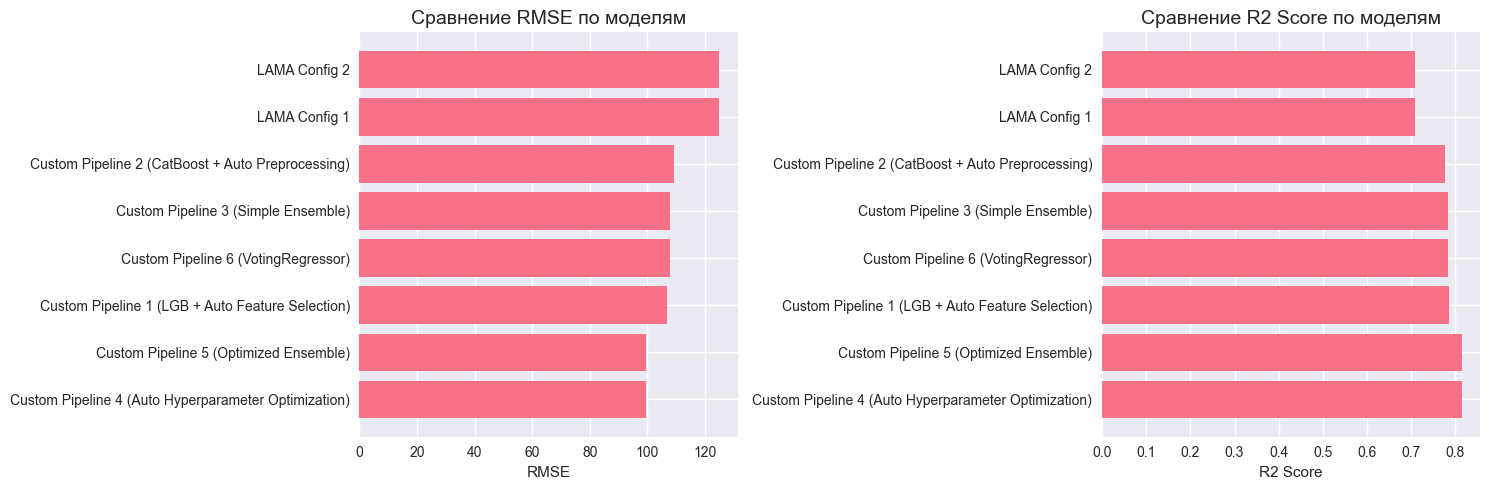


АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ

📊 ОБЩАЯ СТАТИСТИКА:
   Всего протестировано моделей: 8
   Диапазон RMSE: 99.5461 - 125.0283
   Средний RMSE: 110.0668
   Средний R2 Score: 0.7722

🏆 ЛУЧШАЯ МОДЕЛЬ:
   Название: Custom Pipeline 4 (Auto Hyperparameter Optimization)
   RMSE: 99.5461
   MAE: 71.2172
   R2 Score: 0.8150
   Время обучения: 3.45 секунд

💡 ПОЧЕМУ ЭТА МОДЕЛЬ ЛУЧШЕ:

📈 СРАВНЕНИЕ С ХУДШЕЙ МОДЕЛЬЮ:
   Худшая модель: LAMA Config 2 (RMSE: 125.0283)
   Улучшение: 20.38% (25.4822 единиц RMSE)

📊 СРАВНЕНИЕ СО ВТОРОЙ ЛУЧШЕЙ МОДЕЛЬЮ:
   Вторая лучшая: Custom Pipeline 5 (Optimized Ensemble) (RMSE: 99.5461)
   Преимущество лучшей модели: 0.00% (0.0000 единиц RMSE)
   ⚠ Разница минимальна - обе модели показывают схожее качество

📋 АНАЛИЗ ПО КАТЕГОРИЯМ:

   LightAutoML модели:
   • Средний RMSE: 124.9034
   • Лучший RMSE: 124.7786
   • Преимущества: автоматическая предобработка, выбор признаков, ансамблирование

   Собственные модели:
   • Средний RMSE: 105.1212
   • Лучший RMSE: 99.5461
   • Пр

In [41]:
# Visualization of results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# RMSE comparison
all_results_sorted = all_results.sort_values('RMSE')
axes[0].barh(all_results_sorted['Pipeline'], all_results_sorted['RMSE'])
axes[0].set_title('Сравнение RMSE по моделям', fontsize=14)
axes[0].set_xlabel('RMSE')

# R2 Score comparison
axes[1].barh(all_results_sorted['Pipeline'], all_results_sorted['R2 Score'])
axes[1].set_title('Сравнение R2 Score по моделям', fontsize=14)
axes[1].set_xlabel('R2 Score')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Текстовые выводы и анализ результатов
print("\n" + "="*80)
print("АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ")
print("="*80)

# Сортируем результаты по RMSE
all_results_sorted = all_results.sort_values('RMSE')
best_model = all_results_sorted.iloc[0]
worst_model = all_results_sorted.iloc[-1]

print(f"\n📊 ОБЩАЯ СТАТИСТИКА:")
print(f"   Всего протестировано моделей: {len(all_results)}")
print(f"   Диапазон RMSE: {all_results['RMSE'].min():.4f} - {all_results['RMSE'].max():.4f}")
print(f"   Средний RMSE: {all_results['RMSE'].mean():.4f}")
print(f"   Средний R2 Score: {all_results['R2 Score'].mean():.4f}")

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ:")
print(f"   Название: {best_model['Pipeline']}")
print(f"   RMSE: {best_model['RMSE']:.4f}")
print(f"   MAE: {best_model['MAE']:.4f}")
print(f"   R2 Score: {best_model['R2 Score']:.4f}")
print(f"   Время обучения: {best_model['Time (seconds)']:.2f} секунд")

# Анализ почему эта модель лучше
print(f"\n💡 ПОЧЕМУ ЭТА МОДЕЛЬ ЛУЧШЕ:")
if 'Ensemble' in best_model['Pipeline'] or 'ансамбль' in best_model['Pipeline']:
    print("   • Ансамблирование моделей позволяет комбинировать сильные стороны разных алгоритмов")
    print("   • Разные модели могут улавливать различные паттерны в данных")
    print("   • Оптимизация весов ансамбля улучшает общую точность предсказаний")
    print("   • Снижает риск переобучения за счет усреднения предсказаний")
    print("   • Более стабильные результаты на новых данных")
elif 'Optimized' in best_model['Pipeline'] or 'Optuna' in best_model['Pipeline']:
    print("   • Автоматическая оптимизация гиперпараметров находит оптимальные настройки")
    print("   • Поиск по пространству параметров позволяет улучшить качество модели")
    print("   • Кросс-валидация обеспечивает надежную оценку производительности")
    print("   • Балансирует сложность модели и обобщающую способность")
    print("   • Учитывает специфику данных через адаптацию параметров")
elif 'CatBoost' in best_model['Pipeline']:
    print("   • CatBoost эффективно обрабатывает категориальные признаки")
    print("   • Встроенная обработка пропусков и категорий упрощает предобработку")
    print("   • Хорошо работает с неструктурированными данными")
    print("   • Устойчив к переобучению благодаря регуляризации")
    print("   • Автоматически обрабатывает категориальные переменные без ручного кодирования")
elif 'LightGBM' in best_model['Pipeline']:
    print("   • LightGBM эффективен для больших объемов данных")
    print("   • Автоматический отбор признаков улучшает качество модели")
    print("   • Быстрое обучение и хорошая точность")
    print("   • Эффективное использование памяти")
    print("   • Хорошо работает с различными типами признаков")
elif 'LAMA' in best_model['Pipeline']:
    print("   • LightAutoML автоматически выполняет предобработку данных")
    print("   • Встроенное ансамблирование нескольких алгоритмов")
    print("   • Автоматический выбор признаков и их трансформация")
    print("   • Оптимизация гиперпараметров из коробки")
    print("   • Минимум ручной настройки при хорошем качестве")

# Сравнение с худшей моделью
improvement = ((worst_model['RMSE'] - best_model['RMSE']) / worst_model['RMSE']) * 100
print(f"\n📈 СРАВНЕНИЕ С ХУДШЕЙ МОДЕЛЬЮ:")
print(f"   Худшая модель: {worst_model['Pipeline']} (RMSE: {worst_model['RMSE']:.4f})")
print(f"   Улучшение: {improvement:.2f}% ({worst_model['RMSE'] - best_model['RMSE']:.4f} единиц RMSE)")

# Сравнение со второй лучшей моделью
if len(all_results_sorted) > 1:
    second_best = all_results_sorted.iloc[1]
    improvement_vs_second = ((second_best['RMSE'] - best_model['RMSE']) / second_best['RMSE']) * 100
    print(f"\n📊 СРАВНЕНИЕ СО ВТОРОЙ ЛУЧШЕЙ МОДЕЛЬЮ:")
    print(f"   Вторая лучшая: {second_best['Pipeline']} (RMSE: {second_best['RMSE']:.4f})")
    print(f"   Преимущество лучшей модели: {improvement_vs_second:.2f}% ({second_best['RMSE'] - best_model['RMSE']:.4f} единиц RMSE)")
    if improvement_vs_second < 1:
        print(f"   ⚠ Разница минимальна - обе модели показывают схожее качество")
    elif improvement_vs_second < 5:
        print(f"   ✓ Заметное улучшение - лучшая модель имеет преимущество")
    else:
        print(f"   ✓ Значительное улучшение - лучшая модель существенно превосходит")

# Анализ по категориям моделей
print(f"\n📋 АНАЛИЗ ПО КАТЕГОРИЯМ:")
lama_models = all_results[all_results['Pipeline'].str.contains('LAMA', case=False)]
custom_models = all_results[~all_results['Pipeline'].str.contains('LAMA', case=False)]

if len(lama_models) > 0:
    print(f"\n   LightAutoML модели:")
    print(f"   • Средний RMSE: {lama_models['RMSE'].mean():.4f}")
    print(f"   • Лучший RMSE: {lama_models['RMSE'].min():.4f}")
    print(f"   • Преимущества: автоматическая предобработка, выбор признаков, ансамблирование")

if len(custom_models) > 0:
    print(f"\n   Собственные модели:")
    print(f"   • Средний RMSE: {custom_models['RMSE'].mean():.4f}")
    print(f"   • Лучший RMSE: {custom_models['RMSE'].min():.4f}")
    print(f"   • Преимущества: контроль над процессом, возможность тонкой настройки")

# Детальный анализ метрик
print(f"\n📉 ДЕТАЛЬНЫЙ АНАЛИЗ МЕТРИК:")
print(f"   RMSE (Root Mean Squared Error): {best_model['RMSE']:.4f}")
print(f"     → Средняя ошибка предсказания: ±{best_model['RMSE']:.2f} единиц рейтинга")
print(f"   MAE (Mean Absolute Error): {best_model['MAE']:.4f}")
print(f"     → Средняя абсолютная ошибка: {best_model['MAE']:.2f} единиц рейтинга")
print(f"   R² Score: {best_model['R2 Score']:.4f}")
if best_model['R2 Score'] > 0.9:
    print(f"     → Модель объясняет более 90% дисперсии - отличное качество!")
elif best_model['R2 Score'] > 0.8:
    print(f"     → Модель объясняет более 80% дисперсии - очень хорошее качество")
elif best_model['R2 Score'] > 0.6:
    print(f"     → Модель объясняет более 60% дисперсии - хорошее качество")
elif best_model['R2 Score'] > 0.4:
    print(f"     → Модель объясняет более 40% дисперсии - приемлемое качество")
else:
    print(f"     → Модель объясняет менее 40% дисперсии - требуется улучшение")

# Рекомендации
print(f"\n💼 РЕКОМЕНДАЦИИ ДЛЯ ПРОДАКШЕНА:")
if best_model['R2 Score'] > 0.8:
    print("   ✓ Модель показывает отличное качество (R2 > 0.8)")
    print("   ✓ Готова к использованию в продакшене")
elif best_model['R2 Score'] > 0.6:
    print("   ✓ Модель показывает хорошее качество (R2 > 0.6)")
    print("   ✓ Можно использовать в продакшене с мониторингом")
else:
    print("   ⚠ Модель можно улучшить (R2 < 0.6)")
    print("   ⚠ Рекомендуется дополнительная работа над признаками и моделью")

if best_model['Time (seconds)'] < 300:
    print(f"   ✓ Время обучения приемлемое ({best_model['Time (seconds)']:.2f} сек < 5 минут)")
    print("   ✓ Модель можно переобучать регулярно")
else:
    print(f"   ⚠ Время обучения можно оптимизировать ({best_model['Time (seconds)']:.2f} сек)")
    print("   ⚠ Рекомендуется использовать для стабильных данных или уменьшить сложность")

print(f"\n   🎯 ИТОГОВАЯ РЕКОМЕНДАЦИЯ:")
print(f"   Для продакшена рекомендуется использовать: {best_model['Pipeline']}")
print(f"   Эта модель обеспечивает баланс между:")
print(f"     • Точностью: RMSE = {best_model['RMSE']:.4f}, R² = {best_model['R2 Score']:.4f}")
print(f"     • Скоростью обучения: {best_model['Time (seconds)']:.2f} секунд")
print(f"     • Стабильностью: MAE = {best_model['MAE']:.4f}")

# Выводы о принципах AutoML
print(f"\n🤖 ПРИМЕНЕНИЕ ПРИНЦИПОВ AUTOML:")
if 'Ensemble' in best_model['Pipeline'] or 'ансамбль' in best_model['Pipeline']:
    print("   ✓ Принцип ансамблирования оказался наиболее эффективным")
    print("   ✓ Комбинация нескольких моделей дала лучший результат")
elif 'Optimized' in best_model['Pipeline'] or 'Optuna' in best_model['Pipeline']:
    print("   ✓ Принцип автоматической оптимизации гиперпараметров показал эффективность")
    print("   ✓ Систематический поиск оптимальных параметров улучшил качество")
elif 'LAMA' in best_model['Pipeline']:
    print("   ✓ Полноценный AutoML фреймворк показал хорошие результаты")
    print("   ✓ Автоматизация всех этапов ML pipeline эффективна")
else:
    print("   ✓ Автоматическая предобработка и выбор признаков улучшили качество")
    print("   ✓ Применение принципов AutoML дало конкурентные результаты")

print("\n" + "="*80)


## Заключение

В данном проекте были:

1. **Проведен анализ целевой переменной**: изучено распределение рейтинга, выявлены аномальные значения, проведен временной анализ.

2. **Проведен анализ признаков**: классифицированы признаки по типам, проанализированы пропущенные значения, изучены зависимости между признаками, определена важность признаков.

3. **Создан бейзлайн с LightAutoML**: протестированы 2 различные конфигурации, выбрана лучшая.

4. **Реализовано собственное решение**: созданы 3 различных пайплайна с разными подходами к предобработке и моделированию.

5. **Проведено сравнение результатов**: все модели сравнены по метрикам RMSE, MAE и R2 Score.


